# Project Overview: Create a Customer Segmentation Report for Arvato Financial Services

This project will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. Unsupervised learning techniques will be used to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. What was learned in the previous steps will be applied on a third dataset with demographics information for targets of a marketing campaign for the company. In the last step a machine learning model will predict which individuals are most likely to convert into becoming customers for the company. The data for this project has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.cluster import KMeans
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Getting to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Information from the first two files will be used to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then in the analysis predictions will be made on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

In [300]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
feature_values = pd.read_excel('/home/workspace/DIAS Attributes - Values 2017.xlsx', header = 1, usecols = [1,2,3,4]).fillna(method = 'ffill')

In [21]:
feature_attributes = pd.read_excel('/home/workspace/DIAS Information Levels - Attributes 2017.xlsx', header = 1, usecols = [1,2,3,4]).fillna(method = 'ffill')

Take a look at the data sets to see what they reveal.

In [10]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [12]:
feature_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [11]:
feature_attributes.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,modelled on millions of first name-age-referen...
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


Next, examine the data set to see if there are columns that are categorical

In [12]:
customers.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [13]:
customers.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

So, there are a handful of categorical columns. There may be more if they have mixed data types or they have a non linear distribution. This will need to be considered moving forward. 

This data set is very large, 366 columns and 891,221 rows. Working with it can create a lot of data traffic and require large amounts of time sitting and waiting, etc. Therefore it will be reduced in size by 80% so it can be worked with in a more expeditious fashion. There should still be plenty of data to get good unsupervised and supervised models with and that is the goal. 

In [304]:
azdias = azdias.sample(frac = 0.2)

In [94]:
customers.shape

(191652, 369)

The customers_data frame will also be reduced by 60%

In [305]:
customers = customers.sample(frac = 0.5)

In [19]:
azdias.shape

(178244, 366)

In [20]:
customers.shape

(95826, 369)

In [306]:
pickle_out = open("customers.pickle","wb")
pickle.dump(customers, pickle_out)
pickle_out.close()

In [307]:
pickle_out = open("azdias.pickle","wb")
pickle.dump(azdias, pickle_out)
pickle_out.close()

In [22]:
pickle_in = open("customers.pickle","rb")
customers = pickle.load(pickle_in)

In [23]:
pickle_in = open("azdias.pickle","rb")
azdias = pickle.load(pickle_in)

There are some columns in the Azdias data frame that don't have a description in the 'feature_values' csv file. 

In [24]:
attributes_described = list(feature_values["Attribute"].unique())
attributes_described[1:15]

['ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_DEUINTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12']

In [25]:
len(attributes_described)

314

In [26]:
azdias_columns = list(azdias.columns)
azdias_columns[1:20]
len(azdias_columns)

366

In [27]:
customers_columns = customers.columns

Now, find the columns in the 'azdias' frame that don't have a description!

In [28]:
undescribed_columns_azdias = [col for col in customers_columns if col not in attributes_described]

In [29]:
undescribed_columns_azdias[1:15]

['AKT_DAT_KL',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3']

In [30]:
len(undescribed_columns_azdias)

97

So, it appears there are 100 columns in the Azdias data frame that don't have a description for what they mean. For now the columns will be kept regardless of this deficiency. Next, find if there are columns in the 'customers' dataframe that are not in the 'azdias' one. 

In [31]:
extra_columns_customers = [col for col in customers.columns if col not in azdias.columns]
extra_columns_customers

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'). In order to keep the data consistent for comparison matching these 3 columns should be removed from the 'CUSTOMERS' data set. 

In [32]:
customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1)

Next, find out if there are columns in the feature_values dataframe that are not in 'customers' or 'Azdias' dataframe. First, get the unique columns in the feature_values frame!

In [33]:
features_list = list(feature_values['Attribute'].unique())
features_list[1:20]

['ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_DEUINTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ']

In [34]:
feature_columns_to_drop = [col for col in features_list if col not in azdias.columns]

In [35]:
feature_columns_to_drop

['BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB']

Since these features are not actually going to used in the analysis they need to be dropped in order to avoid problems. 

In [36]:
rows_to_drop = feature_values[feature_values['Attribute'].isin(feature_columns_to_drop)]

In [37]:
rows_to_drop.shape

(342, 4)

In [38]:
rows_to_drop[0:10]

,Attribute,Description,Value,Meaning
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,business-flag indicating companies in the buil...,0,no company in the building
50,BIP_FLAG,business-flag indicating companies in the buil...,1,company in the building
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,21,Prosperous Households-Pre-Family Couples & Sin...


In [39]:
rows_to_drop.index

Int64Index([  48,   49,   50,  105,  106,  107,  108,  109,  110,  111,
            ...
            1272, 2207, 2208, 2209, 2238, 2239, 2240, 2241, 2242, 2243],
           dtype='int64', length=342)

Now that the row indices of all useless rows are found they will be dropped from the 'feature_values' frame. 

In [40]:
feature_values.drop(rows_to_drop.index, inplace = True)

In [41]:
feature_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


Now the main data frames ('customers' or 'azdias') will be inspected to see if there are categorical columns.

In [26]:
cat_cols = customers.select_dtypes(include=['object'])
cat_cols.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
176465,2C,2,14,D19_VOLLSORTIMENT,2010-09-16 00:00:00,W
183496,6B,6,43,D19_WEIN_FEINKOST,1992-02-10 00:00:00,W
108099,8C,8,54,D19_DROGERIEARTIKEL,1992-02-12 00:00:00,W
132970,6B,6,43,D19_VOLLSORTIMENT,1992-02-10 00:00:00,W
2253,8A,8,51,D19_HAUS_DEKO,1992-02-10 00:00:00,W


So, now it seems that there are 6 columns of categorical data. 

And using the 'feature_values' frame to find out what they represent yields:

In [27]:
feature_values[feature_values['Attribute'] == 'CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


So it looks like 'CAMEO_DEUG_2015' tells the economic class of someone. They are divided into 9 economic classes so given a categorical value of 1-9, and if it is unknown that person is given a -1. 

In [28]:
feature_values[feature_values['Attribute'] == 'CAMEO_DEU_2015']


,Attribute,Description,Value,Meaning
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
62,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1B,Wealthy Best Ager
63,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1C,Successful Songwriter
64,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1D,Old Nobility
65,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1E,City Nobility
66,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2A,Cottage Chic
67,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2B,Noble Jogger
68,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2C,Established gourmet
69,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2D,Fine Management
70,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,3A,Career & Family


The columns 'CAMEO_DEU_2015' refers to some classification of the person such as retiree, gardener, etc. 

In [29]:
feature_values[feature_values['Attribute'] == 'OST_WEST_KZ']

,Attribute,Description,Value,Meaning
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown
2014,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR)
2015,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG)


And 'OST_WEST_KZ' is some kind of geographic indicator, also contains unknown values

Next check for the 'CAMEO_INTL_2015' category:

In [30]:
feature_values[feature_values['Attribute'] == 'CAMEO_INTL_2015']

,Attribute,Description,Value,Meaning


There is no description available for the CAMEO_INTL_2015 column. Below shows there are mixed values of strings and floats. This will need to be fixed. 

In [40]:
azdias['CAMEO_INTL_2015'].unique()

array(['24', 13.0, 22.0, '45', nan, '23', '51', '14', 23.0, '12', '55',
       51.0, 52.0, '13', 34.0, 43.0, '43', 44.0, '54', 25.0, '33', 41.0,
       24.0, 14.0, '35', '52', '41', 55.0, 35.0, 32.0, 54.0, '31', 31.0,
       '25', '15', 15.0, '34', 33.0, '44', 12.0, '22', '32', 45.0, 'XX'], dtype=object)

After a little research on Google, it was discovered what this data means.  The source is from another project done by another data scientist. Their work was found at: https://jkarakas.github.io/Customer-Demographics-Segmentation-/Customer_Segmentation.html 

Next, the columns with the 'LP' prefix will be explored. They are LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, LP_FAMILIE_FEIN, LP_STATUS_GROB.

In [4]:
feature_values[feature_values['Attribute'] == 'LP_LEBENSPHASE_GROB']

,Attribute,Description,Value,Meaning
1954,LP_LEBENSPHASE_GROB,lifestage rough,1,single low-income- and average earners of youn...
1955,LP_LEBENSPHASE_GROB,lifestage rough,2,single low-income- and average earners of high...
1956,LP_LEBENSPHASE_GROB,lifestage rough,3,single high-income earners
1957,LP_LEBENSPHASE_GROB,lifestage rough,4,single low-income- and average earner-couples
1958,LP_LEBENSPHASE_GROB,lifestage rough,5,single high-income earner-couples
1959,LP_LEBENSPHASE_GROB,lifestage rough,6,single parents
1960,LP_LEBENSPHASE_GROB,lifestage rough,7,single low-income- and average earner-families
1961,LP_LEBENSPHASE_GROB,lifestage rough,8,high-income earner-families
1962,LP_LEBENSPHASE_GROB,lifestage rough,9,average earners of younger age from mulitperso...
1963,LP_LEBENSPHASE_GROB,lifestage rough,10,low-income- and average earners of higher age ...


In [34]:
feature_values[feature_values['Attribute'] == 'LP_LEBENSPHASE_FEIN']

,Attribute,Description,Value,Meaning
1914,LP_LEBENSPHASE_FEIN,lifestage fine,1,single low-income earners of younger age
1915,LP_LEBENSPHASE_FEIN,lifestage fine,2,single low-income earners of middle age
1916,LP_LEBENSPHASE_FEIN,lifestage fine,3,single average earners of younger age
1917,LP_LEBENSPHASE_FEIN,lifestage fine,4,single average earners of middle age
1918,LP_LEBENSPHASE_FEIN,lifestage fine,5,single low-income earners of advanced age
1919,LP_LEBENSPHASE_FEIN,lifestage fine,6,single low-income earners at retirement age
1920,LP_LEBENSPHASE_FEIN,lifestage fine,7,single average earners of advanced age
1921,LP_LEBENSPHASE_FEIN,lifestage fine,8,single average earners at retirement age
1922,LP_LEBENSPHASE_FEIN,lifestage fine,9,single independant persons
1923,LP_LEBENSPHASE_FEIN,lifestage fine,10,wealthy single homeowners


In [35]:
feature_values[feature_values['Attribute'] == 'LP_STATUS_GROB']

,Attribute,Description,Value,Meaning
1976,LP_STATUS_GROB,social status rough,1,low-income earners
1977,LP_STATUS_GROB,social status rough,2,low-income earners
1978,LP_STATUS_GROB,social status rough,3,average earners
1979,LP_STATUS_GROB,social status rough,4,average earners
1980,LP_STATUS_GROB,social status rough,5,average earners
1981,LP_STATUS_GROB,social status rough,6,independants
1982,LP_STATUS_GROB,social status rough,7,independants
1983,LP_STATUS_GROB,social status rough,8,houseowners
1984,LP_STATUS_GROB,social status rough,9,houseowners
1985,LP_STATUS_GROB,social status rough,10,top earners


In [36]:
feature_values[feature_values['Attribute'] == 'LP_STATUS_FEIN']

,Attribute,Description,Value,Meaning
1966,LP_STATUS_FEIN,social status fine,1,typical low-income earners
1967,LP_STATUS_FEIN,social status fine,2,orientationseeking low-income earners
1968,LP_STATUS_FEIN,social status fine,3,aspiring low-income earners
1969,LP_STATUS_FEIN,social status fine,4,villagers
1970,LP_STATUS_FEIN,social status fine,5,minimalistic high-income earners
1971,LP_STATUS_FEIN,social status fine,6,independant workers
1972,LP_STATUS_FEIN,social status fine,7,title holder-households
1973,LP_STATUS_FEIN,social status fine,8,new houseowners
1974,LP_STATUS_FEIN,social status fine,9,houseowners
1975,LP_STATUS_FEIN,social status fine,10,top earners


In [37]:
feature_values[feature_values['Attribute'] == 'LP_FAMILIE_GROB']

,Attribute,Description,Value,Meaning
1903,LP_FAMILIE_GROB,familytyp rough,1,single
1904,LP_FAMILIE_GROB,familytyp rough,2,couple
1905,LP_FAMILIE_GROB,familytyp rough,3,single parent
1906,LP_FAMILIE_GROB,familytyp rough,4,single parent
1907,LP_FAMILIE_GROB,familytyp rough,5,single parent
1908,LP_FAMILIE_GROB,familytyp rough,6,family
1909,LP_FAMILIE_GROB,familytyp rough,7,family
1910,LP_FAMILIE_GROB,familytyp rough,8,family
1911,LP_FAMILIE_GROB,familytyp rough,9,multiperson household
1912,LP_FAMILIE_GROB,familytyp rough,10,multiperson household


In [38]:
feature_values[feature_values['Attribute'] == 'LP_FAMILIE_FEIN']

,Attribute,Description,Value,Meaning
1892,LP_FAMILIE_FEIN,familytyp fine,1,single
1893,LP_FAMILIE_FEIN,familytyp fine,2,couple
1894,LP_FAMILIE_FEIN,familytyp fine,3,young single parent
1895,LP_FAMILIE_FEIN,familytyp fine,4,single parent with teenager
1896,LP_FAMILIE_FEIN,familytyp fine,5,single parent with child of full age
1897,LP_FAMILIE_FEIN,familytyp fine,6,young family
1898,LP_FAMILIE_FEIN,familytyp fine,7,family with teenager
1899,LP_FAMILIE_FEIN,familytyp fine,8,family with child of full age
1900,LP_FAMILIE_FEIN,familytyp fine,9,shared flat
1901,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household


So, upon inspection it looks like 'LP_LEBENSPAHSE_FEIN' and 'LP_LEBENSPAHSE_GROB' provide information about the income class and also about the marital status, family type, and or age group. The fact that this column has a lot of different kinds of information implies it should need some feature engineering performed on it so the information it provides is more particular into separate columns. 

In [35]:
feature_values[feature_values['Attribute'] == 'D19_LETZTER_KAUF_BRANCHE']

,Attribute,Description,Value,Meaning


Again, no description os available for the D19_LETZTER_KAUF_BRANCHE column either. But from translation of the words it means "Last Purchase Sector". 

Next, inspect the column 'PRAEGENDE_JUGENDJAHRE'. 

In [122]:
feature_values[feature_values['Attribute'] == 'PRAEGENDE_JUGENDJAHRE']

,Attribute,Description,Value,Meaning
2054,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,"-1, 0",unknown
2055,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,1,"40ies - war years (Mainstream, O+W)"
2056,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,2,"40ies - reconstruction years (Avantgarde, O+W)"
2057,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,3,"50ies - economic miracle (Mainstream, O+W)"
2058,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,4,50ies - milk bar / Individualisation (Avantgar...
2059,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,5,"60ies - economic miracle (Mainstream, O+W)"
2060,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,6,60ies - generation 68 / student protestors (Av...
2061,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,7,60ies - opponents to the building of the Wall ...
2062,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,8,"70ies - family orientation (Mainstream, O+W)"
2063,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,9,"70ies - peace movement (Avantgarde, O+W)"


'PRAEGENDE_JUGENDJAHRE' looks like another column that has more than one kind of information about it. It has information about the decade associated with the person and some other socio-demographic information about them. Therefore this column will be split up into new columns later. 

In [36]:
unique_classes = []
for j in (cat_cols):
    unique_classes.append(cat_cols[j].unique())

Now it can be seen what the unique classes are for each categorical category:

In [37]:
cat_col_names = cat_cols.columns
for i in zip(cat_col_names, unique_classes):
    print(i)

('CAMEO_DEU_2015', array([nan, '2C', '2A', '7A', '5A', '8D', '6B', '2D', '6E', '1C', '5D',
       '4E', '3C', '1E', '4D', '8C', '4A', '9D', '3D', '5F', '2B', '7E',
       '5B', '6A', '3A', '1B', '9A', '1D', '5C', '6C', '7D', '4C', '9C',
       '6F', '7C', '1A', '8A', '8B', '5E', '7B', '6D', '3B', '9B', '4B',
       '9E', 'XX'], dtype=object))
('CAMEO_DEUG_2015', array([nan, '2', '7', '5', '8', '6', 2.0, 7.0, '1', 4.0, '3', '4', 8.0,
       5.0, 9.0, 3.0, '9', 6.0, 1.0, 'X'], dtype=object))
('CAMEO_INTL_2015', array([nan, '14', '12', '41', '31', '55', '43', 14.0, 41.0, '45', '34',
       25.0, '24', '15', 54.0, '22', 31.0, 51.0, '25', '35', 13.0, '54',
       '32', 23.0, '23', '52', 24.0, '13', 33.0, 22.0, '44', '51', 45.0,
       15.0, 43.0, 12.0, '33', 34.0, 52.0, 'XX', 44.0, 35.0, 32.0, 55.0], dtype=object))
('D19_LETZTER_KAUF_BRANCHE', array([nan, 'D19_SCHUHE', 'D19_UNBEKANNT', 'D19_BUCH_CD', 'D19_REISEN',
       'D19_VOLLSORTIMENT', 'D19_VERSAND_REST', 'D19_BEKLEIDUNG_GEH',
       

## Visualizing and Cleaning the Data

Before the data can be analyzed and predictions about the customers made the data needs to be looked at as closely as possible to see if there are chunks of it missing, if there are inconsistencies, etc. that need to be dealt with first. This step is the most intenstive and time consuming part of the project as it requires inspection of about 366 columns of data and it is evident that there are many steps to organize the data in a reasonable fashion. 

The column with the dates ['EINGEFUEGT_AM'], would be a good place to start.
So, to simply the column with the dates "customers['EINGEFUEGT_AM']", just take the year and the month and place them in new columns, then drop the original, and then repeat for the 'azdias' dataframe!

Repeat the above steps for the azdias and customers data frames. 

In [42]:
customers['year'] = pd.DatetimeIndex(customers['EINGEFUEGT_AM']).year

In [43]:
customers = customers.drop(['EINGEFUEGT_AM'], axis=1)
customers = pd.DataFrame(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
176465,18214,2,5.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,6.0,8.0,0.0,3,2,4,2010.0
183496,87600,2,1.0,19.0,NaN,NaN,NaN,NaN,10.0,4.0,...,2.0,1.0,2.0,2.0,9.0,7.0,3,1,3,1992.0
108099,172050,-1,1.0,14.0,NaN,NaN,NaN,NaN,0.0,1.0,...,3.0,5.0,3.0,4.0,9.0,3.0,1,1,4,1992.0
132970,66654,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,4.0,...,6.0,6.0,3.0,2.0,9.0,1.0,1,1,4,1992.0
2253,166710,1,2.0,9.0,NaN,NaN,NaN,NaN,9.0,14.0,...,8.0,4.0,2.0,6.0,9.0,3.0,6,2,1,1992.0


In [44]:
azdias['year'] = pd.DatetimeIndex(azdias['EINGEFUEGT_AM']).year

In [45]:
azdias = azdias.drop(['EINGEFUEGT_AM'], axis=1)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
395430,777255,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
620626,298340,-1,1.0,17.0,16.0,16.0,NaN,NaN,17.0,4.0,...,5.0,8.0,8.0,1.0,9.0,7.0,4,2,1,1996.0
376138,914305,-1,1.0,16.0,NaN,NaN,NaN,NaN,16.0,1.0,...,2.0,3.0,2.0,2.0,9.0,7.0,1,1,3,1996.0
229799,1015208,-1,9.0,16.0,NaN,NaN,NaN,NaN,NaN,9.0,...,6.0,9.0,8.0,2.0,6.0,4.0,3,2,1,1992.0
594744,271589,-1,9.0,16.0,NaN,NaN,NaN,NaN,NaN,2.0,...,9.0,9.0,6.0,6.0,9.0,2.0,3,2,4,2006.0


When the data frames were first uploaded there were some warning messages "Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False." Therefore these columns and their missing data should be dealt with. 

In [35]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [36]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan, '5', '4', 8.0, '7', '2', '6', 2.0, '8', 7.0, 5.0, 4.0, '9',
       9.0, '3', 6.0, '1', 3.0, 1.0, 'X'], dtype=object)

In [37]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, '33', '24', 54.0, '45', '12', '43', 13.0, '41', 45.0, 34.0,
       23.0, '31', 55.0, '51', 51.0, 25.0, '22', '13', '54', 41.0, 24.0,
       '25', 43.0, 14.0, '55', '23', '14', 22.0, 12.0, '34', '15', 31.0,
       '35', 33.0, '44', 52.0, 32.0, 44.0, '32', 15.0, 35.0, '52', 'XX'], dtype=object)

There are values of 'X' and 'XX' given in these columns and they don't confer with the other values. They will be replaced with NaN's 

In [46]:
def convert_X(df):
    """
    Replaces values of 'X' and 'XX' with NaN and converts all values in the column to a float

    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.NaN, "XX": np.NaN})
    df[cols] = df[cols].astype(float)
    
    return df

In [47]:
convert_X(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
176465,18214,2,5.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,6.0,8.0,0.0,3,2,4,2010.0
183496,87600,2,1.0,19.0,NaN,NaN,NaN,NaN,10.0,4.0,...,2.0,1.0,2.0,2.0,9.0,7.0,3,1,3,1992.0
108099,172050,-1,1.0,14.0,NaN,NaN,NaN,NaN,0.0,1.0,...,3.0,5.0,3.0,4.0,9.0,3.0,1,1,4,1992.0
132970,66654,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,4.0,...,6.0,6.0,3.0,2.0,9.0,1.0,1,1,4,1992.0
2253,166710,1,2.0,9.0,NaN,NaN,NaN,NaN,9.0,14.0,...,8.0,4.0,2.0,6.0,9.0,3.0,6,2,1,1992.0


In [48]:
convert_X(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
395430,777255,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
620626,298340,-1,1.0,17.0,16.0,16.0,NaN,NaN,17.0,4.0,...,5.0,8.0,8.0,1.0,9.0,7.0,4,2,1,1996.0
376138,914305,-1,1.0,16.0,NaN,NaN,NaN,NaN,16.0,1.0,...,2.0,3.0,2.0,2.0,9.0,7.0,1,1,3,1996.0
229799,1015208,-1,9.0,16.0,NaN,NaN,NaN,NaN,NaN,9.0,...,6.0,9.0,8.0,2.0,6.0,4.0,3,2,1,1992.0
594744,271589,-1,9.0,16.0,NaN,NaN,NaN,NaN,NaN,2.0,...,9.0,9.0,6.0,6.0,9.0,2.0,3,2,4,2006.0


Next, double check to make sure it worked. 

In [41]:
azdias['CAMEO_DEUG_2015'].unique()

array([ nan,   5.,   4.,   8.,   7.,   2.,   6.,   9.,   3.,   1.])

In [42]:
azdias['CAMEO_INTL_2015'].unique()

array([ nan,  33.,  24.,  54.,  45.,  12.,  43.,  13.,  41.,  34.,  23.,
        31.,  55.,  51.,  25.,  22.,  14.,  15.,  35.,  44.,  52.,  32.])

In [43]:
customers['CAMEO_DEUG_2015'].unique()

array([  2.,   6.,   8.,   4.,   9.,  nan,   1.,   5.,   7.,   3.])

In [44]:
customers['CAMEO_INTL_2015'].unique()

array([ 14.,  43.,  54.,  51.,  22.,  nan,  12.,  13.,  35.,  34.,  24.,
        44.,  55.,  15.,  52.,  23.,  45.,  41.,  31.,  25.,  32.,  33.])

This all checks out fine. 

Next, it looks like the dataframes have a lot of unknown values, represented by 0, -1, or nan. This will be handled by converting all unknowns to nan's. 

In [49]:
unknown_df = feature_values[feature_values['Meaning']=='unknown']
unknown_df

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
647,EWDICHTE,density of inhabitants per square kilometer,-1,unknown
654,FINANZTYP,best descirbing financial type for the person,-1,unknown
661,FINANZ_ANLEGER,financial typology: investor,-1,unknown
667,FINANZ_HAUSBAUER,financial typology: main focus is the own house,-1,unknown


In [50]:
unknown = pd.Series(unknown_df['Value'].values, index=unknown_df['Attribute'])
unknown[1:10]

Attribute
ALTERSKATEGORIE_GROB    -1, 0
ANREDE_KZ               -1, 0
BALLRAUM                   -1
CAMEO_DEUG_2015            -1
CJT_GESAMTTYP               0
EWDICHTE                   -1
FINANZTYP                  -1
FINANZ_ANLEGER             -1
FINANZ_HAUSBAUER           -1
dtype: object

Get a list of columns of the dataframe where the unknown values are = -1. 

In [51]:
neg_one_columns = unknown_df[unknown_df['Value']==-1].Attribute
neg_one_columns = list(neg_one_columns)
neg_one_columns

['AGER_TYP',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'HEALTH_TYP',
 'INNENSTADT',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA13_ALTERHALTER_30',
 'KBA13_ALTERHALTER_45',
 'KBA13_ALTERHALTER_60',
 'KBA13_ALTERHALTER_61',
 'KBA13_AUDI',
 'KBA13_AUTOQUOTE',
 'KBA13_BJ_1999',
 'KBA13_BJ_2000',
 'KBA13_BJ_2004',
 'KBA13_BJ_2006',
 'KBA13_BJ_2008',
 'KBA13_BJ_2009',
 'KBA13_BMW',
 'KBA13_CCM_1000',
 'KBA13_CCM_1200',
 'KBA13_CCM_1400',
 'KBA13_CCM_0_1400',
 'KBA13_CCM_1500',
 'KBA13_CCM_1600',
 'KBA13_CCM_1800',
 'KBA13_CCM_2000',
 'KBA13_CCM_2500',
 'KBA13_CCM_2501',
 'KBA13_CCM_3000',
 'KBA13_CCM_3001',
 'KBA13_FAB_ASIEN',
 'KBA13_FAB_SONSTIGE',
 'KBA13_FIAT',
 'KBA13_FORD',
 'KBA13_HALTER_20',
 'KBA13_HALTER_25',
 'KBA13_HALTER_30',
 'KBA13_HALTER_35',
 'KBA13_HALTER_40',
 'KBA13_HALTER_45',
 'KBA13_HALTER_50',
 'KBA1

Next, get the unknown columns that have unknown values of '-1, 0'.

In [48]:
neg_one_and_zero_columns = unknown_df[unknown_df['Value'] == '-1, 0'].Attribute
neg_one_and_zero_columns = list(neg_one_and_zero_columns)
neg_one_and_zero_columns

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'GEBAEUDETYP',
 'HH_EINKOMMEN_SCORE',
 'KBA05_BAUMAX',
 'KBA05_GBZ',
 'KKK',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'REGIOTYP',
 'TITEL_KZ',
 'WOHNDAUER_2008',
 'W_KEIT_KIND_HH']

Next, get the columns that have '-1, 9' as an unknown value

In [49]:
neg_one_and_nine_columns = unknown_df[unknown_df['Value'] == '-1, 9'].Attribute
neg_one_and_nine_columns = list(neg_one_and_nine_columns)
neg_one_and_nine_columns[1:15]

['KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4',
 'KBA05_ANHANG',
 'KBA05_AUTOQUOT',
 'KBA05_CCM1',
 'KBA05_CCM2',
 'KBA05_CCM3',
 'KBA05_CCM4',
 'KBA05_DIESEL',
 'KBA05_FRAU',
 'KBA05_HERST1',
 'KBA05_HERST2',
 'KBA05_HERST3']

And the last set of unknown columns is those that have '0' as an unknown value.

In [50]:
zero_columns = unknown_df[unknown_df['Value'] == 0].Attribute
zero_columns = list(zero_columns)
zero_columns

['CJT_GESAMTTYP', 'RETOURTYP_BK_S']

In this step, four different functions are written that will replace the four different kinds of unknown values that are in the 'azdias' and 'customers' dataframes. Apparently there are columns that have unknown values imputed by '-1, 0'. Inspect the unique values of those columns to see if this is the case. 

In [51]:
for cols in azdias.columns:
    if cols in neg_one_and_zero_columns:
        print(cols, azdias[cols].unique())

GEBAEUDETYP [ nan   1.   3.   8.   2.   6.   4.]
HH_EINKOMMEN_SCORE [  2.   6.   3.   4.   1.   5.  nan]
KBA05_BAUMAX [ nan   0.   1.   2.   3.   4.   5.]
KBA05_GBZ [ nan   4.   2.   5.   1.   3.]
KKK [ nan   4.   2.   1.   0.   3.]
NATIONALITAET_KZ [0 1 2 3]
PRAEGENDE_JUGENDJAHRE [ 0 14 11  2  5  8  3  9 15 10 13 12  6  4  1  7]
REGIOTYP [ nan   5.   2.   4.   0.   3.   7.   6.   1.]
TITEL_KZ [ nan   0.   1.   3.   5.   4.]
W_KEIT_KIND_HH [ nan   1.   2.   6.   4.   3.   5.   0.]
WOHNDAUER_2008 [ nan   9.   6.   5.   4.   8.   7.   3.   2.   1.]
ANREDE_KZ [1 2]
ALTERSKATEGORIE_GROB [2 1 3 4 9]


It doesn't appear that there are any values of '-1, 0'. Rather, the unknown values are labled with 'nan' so nothing needs to be done about this. 

In [52]:
for cols in azdias.columns:
    if cols in neg_one_columns:
        print(cols, azdias[cols].unique())

AGER_TYP [-1  3  1  2  0]
BALLRAUM [ nan   6.   2.   7.   4.   1.   3.   5.]
CAMEO_DEUG_2015 [ nan   5.   4.   8.   7.   2.   6.   9.   3.   1.]
EWDICHTE [ nan   1.   2.   4.   6.   5.   3.]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_HAUSBAUER [3 4 1 5 2]
FINANZ_MINIMALIST [3 1 5 4 2]
FINANZ_SPARER [4 2 5 1 3]
FINANZ_UNAUFFAELLIGER [5 3 2 4 1]
FINANZ_VORSORGER [3 1 4 5 2]
FINANZTYP [4 1 6 2 5 3]
HEALTH_TYP [-1  3  2  1]
INNENSTADT [ nan   7.   5.   8.   4.   6.   2.   3.   1.]
KBA05_ANTG1 [ nan   1.   4.   0.   3.   2.]
KBA05_ANTG2 [ nan   2.   1.   4.   0.   3.]
KBA05_ANTG3 [ nan   0.   1.   2.   3.]
KBA05_ANTG4 [ nan   0.   1.   2.]
KBA13_ALTERHALTER_30 [ nan   5.   3.   1.   4.   2.]
KBA13_ALTERHALTER_45 [ nan   2.   4.   3.   5.   1.]
KBA13_ALTERHALTER_60 [ nan   4.   3.   5.   1.   2.]
KBA13_ALTERHALTER_61 [ nan   2.   4.   3.   1.   5.]
KBA13_AUDI [ nan   3.   2.   1.   4.   5.]
KBA13_AUTOQUOTE [ nan   4.   3.   2.   1.   5.   0.]
KBA13_BJ_1999 [ nan   1.   3.   2.   4.   5.]
KBA13_BJ_200

It looks like most of the columns don't have -1 imputed for unkown values, they have 'nan', but there are few that have -1 for the unkown value. The function below will convert this unknown value to a an 'nan'. 

In [52]:
def convert_neg_ones(df):
    """
    Replaces values of '-1' with NaN 
    
    INPUT:
    -df: A dataframe
    
    OUTPUT:
    -df: A dataframe with columns that have been cleaned

    """
    df[neg_one_columns] = df[neg_one_columns].replace({-1: np.nan})
   
    return df

In [53]:
convert_neg_ones(customers)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
176465,18214,2.0,5.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,6.0,8.0,0.0,3,2,4,2010.0
183496,87600,2.0,1.0,19.0,NaN,NaN,NaN,NaN,10.0,4.0,...,2.0,1.0,2.0,2.0,9.0,7.0,3,1,3,1992.0
108099,172050,NaN,1.0,14.0,NaN,NaN,NaN,NaN,0.0,1.0,...,3.0,5.0,3.0,4.0,9.0,3.0,1,1,4,1992.0
132970,66654,NaN,1.0,0.0,NaN,NaN,NaN,NaN,14.0,4.0,...,6.0,6.0,3.0,2.0,9.0,1.0,1,1,4,1992.0
2253,166710,1.0,2.0,9.0,NaN,NaN,NaN,NaN,9.0,14.0,...,8.0,4.0,2.0,6.0,9.0,3.0,6,2,1,1992.0
122865,43251,NaN,1.0,17.0,11.0,14.0,NaN,NaN,0.0,1.0,...,2.0,4.0,2.0,1.0,9.0,7.0,4,1,4,1992.0
116569,23549,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,1.0,...,1.0,1.0,1.0,6.0,9.0,3.0,3,1,4,1992.0
43498,23373,1.0,1.0,7.0,NaN,NaN,NaN,NaN,7.0,7.0,...,10.0,13.0,10.0,NaN,9.0,4.0,3,2,4,1992.0
118421,18953,NaN,2.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,8.0,11.0,9.0,6.0,9.0,3.0,4,2,4,1992.0
187097,46233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,1,NaN


In [55]:
for cols in azdias.columns:
    if cols in neg_one_and_nine_columns:
        print(cols, azdias[cols].unique())

KBA05_ALTER1 [ nan   3.   2.   0.   1.   4.   9.]
KBA05_ALTER2 [ nan   2.   4.   3.   1.   5.   9.]
KBA05_ALTER3 [ nan   5.   4.   3.   1.   2.   9.]
KBA05_ALTER4 [ nan   1.   3.   5.   2.   4.   0.   9.]
KBA05_ANHANG [ nan   3.   1.   0.   2.   9.]
KBA05_AUTOQUOT [ nan   3.   4.   5.   2.   1.   9.]
KBA05_CCM1 [ nan   2.   5.   3.   4.   1.   9.]
KBA05_CCM2 [ nan   5.   4.   3.   2.   1.   9.]
KBA05_CCM3 [ nan   2.   3.   1.   4.   5.   9.]
KBA05_CCM4 [ nan   1.   0.   3.   4.   2.   9.]
KBA05_DIESEL [ nan   1.   2.   0.   3.   4.   9.]
KBA05_FRAU [ nan   2.   1.   4.   3.   5.   9.]
KBA05_HERST1 [ nan   0.   4.   2.   1.   3.   5.   9.]
KBA05_HERST2 [ nan   2.   3.   4.   1.   5.   9.]
KBA05_HERST3 [ nan   4.   3.   5.   2.   1.   0.   9.]
KBA05_HERST4 [ nan   3.   1.   2.   5.   4.   9.   0.]
KBA05_HERST5 [ nan   4.   3.   1.   2.   5.   0.   9.]
KBA05_HERSTTEMP [ nan   3.   1.   5.   2.   9.   4.]
KBA05_KRSAQUOT [ nan   3.   4.   5.   1.   2.   9.]
KBA05_KRSHERST1 [ nan   2.   4.  

In [56]:
for cols in azdias.columns:
    if cols in neg_one_and_nine_columns:
        print(cols, customers[cols].unique())

KBA05_ALTER1 [ nan   1.   2.   0.   3.   9.   4.]
KBA05_ALTER2 [ nan   3.   5.   1.   9.   4.   2.]
KBA05_ALTER3 [ nan   4.   3.   2.   1.   9.   5.]
KBA05_ALTER4 [ nan   3.   4.   5.   9.   0.   2.   1.]
KBA05_ANHANG [ nan   1.   3.   0.   9.   2.]
KBA05_AUTOQUOT [ nan   3.   5.   2.   1.   9.   4.]
KBA05_CCM1 [ nan   2.   1.   3.   9.   4.   5.]
KBA05_CCM2 [ nan   2.   4.   1.   3.   9.   5.]
KBA05_CCM3 [ nan   5.   3.   9.   4.   1.   2.]
KBA05_CCM4 [ nan   1.   2.   0.   3.   9.   4.]
KBA05_DIESEL [ nan   2.   3.   4.   9.   1.   0.]
KBA05_FRAU [ nan   5.   3.   1.   2.   9.   4.]
KBA05_HERST1 [ nan   3.   2.   1.   5.   9.   4.   0.]
KBA05_HERST2 [ nan   3.   2.   4.   9.   5.   1.]
KBA05_HERST3 [ nan   3.   5.   2.   9.   4.   1.   0.]
KBA05_HERST4 [ nan   3.   4.   5.   1.   9.   0.   2.]
KBA05_HERST5 [ nan   2.   4.   0.   9.   5.   3.   1.]
KBA05_HERSTTEMP [  5.   4.   3.   1.   2.  nan   9.]
KBA05_KRSAQUOT [ nan   2.   5.   3.   1.   9.   4.]
KBA05_KRSHERST1 [ nan   3.   2.  

As is the case with the columns that supposedly has '-1, 0' imputed for unknown values there does not appear to be any that columns that have '-1, 9' for an unknown either. 

In [57]:
for cols in azdias.columns:
    if cols in zero_columns:
        print(cols, azdias[cols].unique())

CJT_GESAMTTYP [  6.   4.   2.   1.   3.   5.  nan]
RETOURTYP_BK_S [  3.   1.   5.   2.   4.  nan]


As is the case with the columns that supposedly has '-1, 0' imputed for unknown values there does not appear to be any that columns that have '-1, 9', or 0 for an unknown either.

Now columns that have '-1' instead of what they should have, 'nan' will be fixed with the replacement of 'nan'. 

In [54]:
convert_neg_ones(customers)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
176465,18214,2.0,5.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,6.0,8.0,0.0,3,2,4,2010.0
183496,87600,2.0,1.0,19.0,NaN,NaN,NaN,NaN,10.0,4.0,...,2.0,1.0,2.0,2.0,9.0,7.0,3,1,3,1992.0
108099,172050,NaN,1.0,14.0,NaN,NaN,NaN,NaN,0.0,1.0,...,3.0,5.0,3.0,4.0,9.0,3.0,1,1,4,1992.0
132970,66654,NaN,1.0,0.0,NaN,NaN,NaN,NaN,14.0,4.0,...,6.0,6.0,3.0,2.0,9.0,1.0,1,1,4,1992.0
2253,166710,1.0,2.0,9.0,NaN,NaN,NaN,NaN,9.0,14.0,...,8.0,4.0,2.0,6.0,9.0,3.0,6,2,1,1992.0


In [55]:
convert_neg_ones(azdias)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year
395430,777255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN
620626,298340,NaN,1.0,17.0,16.0,16.0,NaN,NaN,17.0,4.0,...,5.0,8.0,8.0,1.0,9.0,7.0,4,2,1,1996.0
376138,914305,NaN,1.0,16.0,NaN,NaN,NaN,NaN,16.0,1.0,...,2.0,3.0,2.0,2.0,9.0,7.0,1,1,3,1996.0
229799,1015208,NaN,9.0,16.0,NaN,NaN,NaN,NaN,NaN,9.0,...,6.0,9.0,8.0,2.0,6.0,4.0,3,2,1,1992.0
594744,271589,NaN,9.0,16.0,NaN,NaN,NaN,NaN,NaN,2.0,...,9.0,9.0,6.0,6.0,9.0,2.0,3,2,4,2006.0


In [60]:
azdias.shape

(178244, 366)

In this step the columns that have index of 'FEIN' and also 'GROB' will be inspected with bar_plot to get further insight to them:
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB'.
 Additionally, other various columns will be inspected with bar plots to see if anything about them needs to be fixed. 

In [67]:
def plot_bar(df, col_name):
    """
    INPUT:
    - A dataframe
    - A column name
    
    OUTPUT:
    - A bar plot of the column's values for a dataframe
    """
    df[col_name].value_counts().plot.bar()

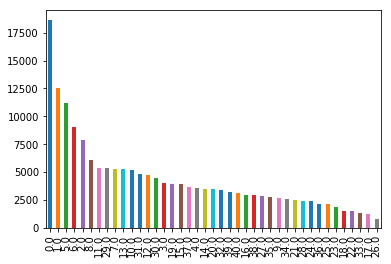

In [99]:
plot_bar(azdias, 'LP_LEBENSPHASE_FEIN')

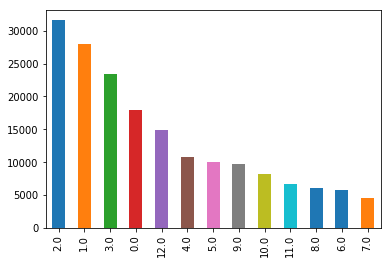

In [79]:
plot_bar(azdias, 'LP_LEBENSPHASE_GROB')

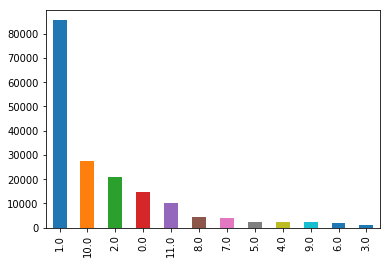

In [80]:
plot_bar(azdias, 'LP_FAMILIE_FEIN')

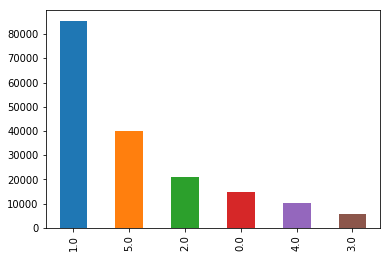

In [81]:
plot_bar(azdias, 'LP_FAMILIE_GROB')

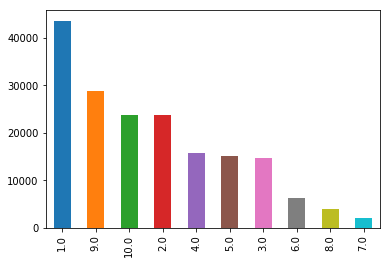

In [82]:
plot_bar(azdias, 'LP_STATUS_FEIN')

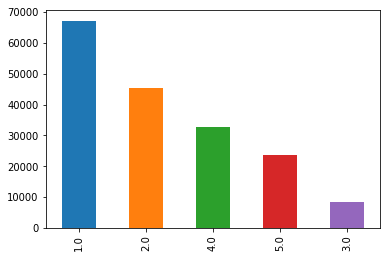

In [83]:
plot_bar(azdias, 'LP_STATUS_GROB')

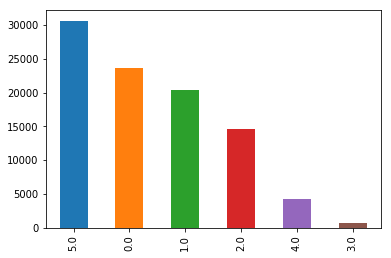

In [88]:
plot_bar(customers, 'LP_FAMILIE_GROB' )

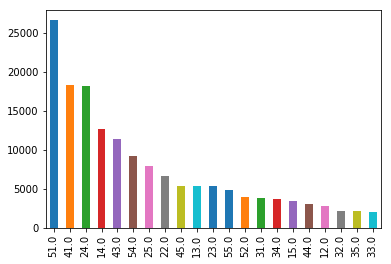

In [89]:
plot_bar(azdias, 'CAMEO_INTL_2015')

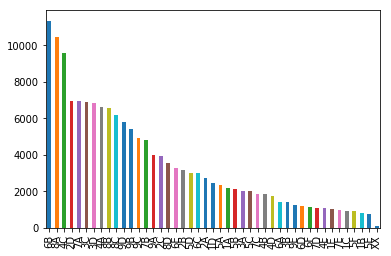

In [90]:
plot_bar(azdias, 'CAMEO_DEU_2015')

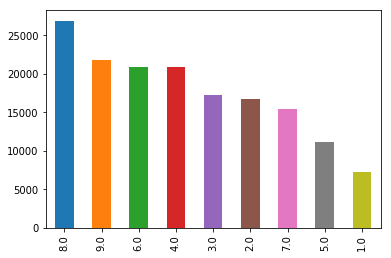

In [131]:
plot_bar(azdias, 'CAMEO_DEUG_2015')

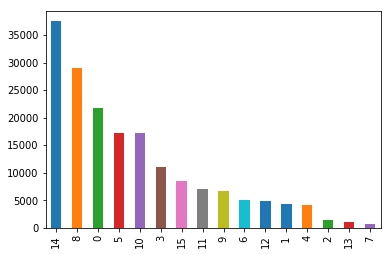

In [91]:
plot_bar(azdias, 'PRAEGENDE_JUGENDJAHRE')

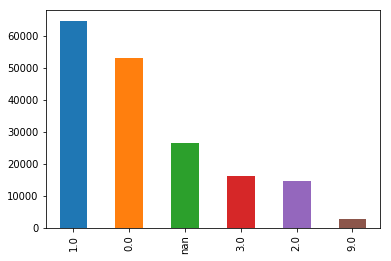

In [92]:
plot_bar(azdias, 'KBA05_ANHANG')

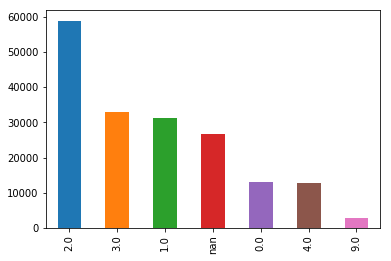

In [93]:
plot_bar(azdias, 'KBA05_DIESEL')

As can be seen, the distinction between 'FEIN' and 'GROS' is that the first is more corse than the other. Also, 'CAMEO_DEU_2015' looks like the 'fine' version of 'CAMEO_DEUG_2015'.

So, earlier on the columns with 'LP' in front of them were inspected and it was found that they had mixed information stored in them. The function below 'fix_LP_cols' will fix this by mapping the values to what they represent. 

In [56]:
def fix_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)  

    return df

In [57]:
customers = fix_LP_cols(customers)

In [58]:
azdias = fix_LP_cols(azdias)

And at last a function that will map out the values of 'CAMEO_INTL_2015' to its values. Note there there are two kinds of data here as well relating to affluency level and family type. 

In [59]:
def fix_cameo_intl_col(df):
    ''' Breaks up  two-digit codes by their
    'tens'-place and 'ones'-place digits
    into two new ordinal variables.
    Leaves NaNs unchanged'''
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

In [60]:
azdias = fix_cameo_intl_col(azdias)
customers = fix_cameo_intl_col(customers)

Now some columns will be dropped. The more granular versions of data will be dropped for the 'LP_STATUS', 'LP_FAMILIE_FEIN', and 'CAMEO_DEU_2015'.

In [61]:
customers = customers.drop(['LP_STATUS_FEIN','LP_FAMILIE_FEIN', 'CAMEO_DEU_2015'], axis = 1)
azdias = azdias.drop(['LP_STATUS_FEIN','LP_FAMILIE_FEIN', 'CAMEO_DEU_2015'], axis = 1)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
395430,777255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,1,2,NaN,NaN,NaN,NaN
620626,298340,NaN,1.0,17.0,16.0,16.0,NaN,NaN,17.0,4.0,...,1.0,9.0,7.0,4,2,1,1996.0,22.0,3.0,3.0
376138,914305,NaN,1.0,16.0,NaN,NaN,NaN,NaN,16.0,1.0,...,2.0,9.0,7.0,1,1,3,1996.0,33.0,2.0,4.0
229799,1015208,NaN,9.0,16.0,NaN,NaN,NaN,NaN,NaN,9.0,...,2.0,6.0,4.0,3,2,1,1992.0,29.0,5.0,4.0
594744,271589,NaN,9.0,16.0,NaN,NaN,NaN,NaN,NaN,2.0,...,6.0,9.0,2.0,3,2,4,2006.0,12.0,2.0,4.0


In [330]:
print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

[ nan   2.   0.   1.]
[  0.   1.  nan]
[ nan   1.   2.   3.]
[ nan   2.   1.   4.   3.]


As it was explored earlier in the data inspection steps, the column PRAEGENDE_JUGENDJAHRE contains two different categories of information. What decade the person grew up and also if they are associated with a certain cultural movement such as ecologically minded, anti-war, etc. Two new colummns (DECADE and MOVEMENT) will be created from this one. 

In [62]:
def convert_pj_to_dec(val):
    """
    Converts value of feature PRAEGENDE_JUGENDJAHRE to a DECADE value.

    INPUT:
    - val (int): original value

    OUTPUT:
    - int: converted value (0: 40s, 1: 50s, 2: 60s, 3: 70s, 4: 80s, 5: 90s)
    """
    
    result = val
    if (val > 0 and val <= 2):
        result = 0 #40s
    elif (val <= 4):
        result = 1 #50s
    elif (val <= 7):
        result = 2 #60s
    elif (val <= 9):
        result = 3 #70s
    elif (val <= 13):
        result = 4 #80s
    elif (val <= 15):
        result = 5 #90
    return result

def convert_pj_to_move(val):
    """
    Converts value of feature PRAEGENDE_JUGENDJAHRE to a MOVEMENT value.

    INPUT:
    - val (int): original value

    OUTPUT:
    - int: converted value (0: Mainstream, 1: Avantgarde)
    """
    
    result = val
    if (val in [1,3,5,8,10,12,14]):
        result = 0 # M
    elif (val in [2,4,6,7,9,11,13,15]):
        result = 1 # A
    return result


In [63]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_dec(x))
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_move(x))

# drop PRAEGENDE_JUGENDJAHRE
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [64]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
customers['DECADE'] = customers['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_dec(x))
customers['MOVEMENT'] = customers['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_move(x))

# drop PRAEGENDE_JUGENDJAHRE
customers.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

One other column will be looked at. 'OST_WEST_KZ'. It is a categorical variable based on the earlier inspection of categorical variables. These categorical values 'W' and 'O' will be converted to binary.  

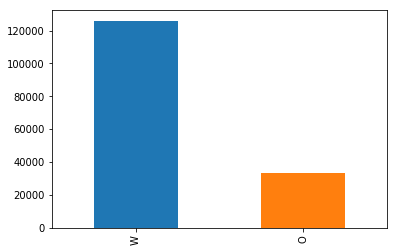

In [74]:
plot_bar(azdias, 'OST_WEST_KZ')

In [65]:
def convert_mixed(df, col_name):
    """
    Converts a dataframe's columns with mixed values and converts the values all to float
    
    INPUT:
    - df: A dataframe
    - col_name: The name of the column in the dataframe
    
    OUTPUT:
    - df_col: An organized column whose values are more consistent and of the same data type. 
    """
    df_col = df[col_name]
    values = df_col.value_counts(ascending = False)
    df_col = pd.DataFrame(df_col)
    prior_values = values.index
    prior_values = list(prior_values)
    new_values =  list(range(len(prior_values)))
    df_col = df_col.replace(prior_values, new_values)   
    return df_col

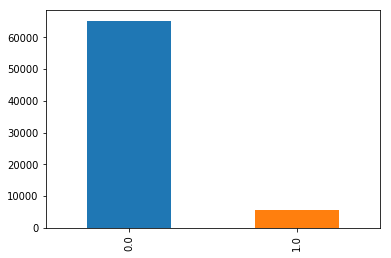

In [68]:
customers['OST_WEST_KZ'] = convert_mixed(customers, 'OST_WEST_KZ')
plot_bar(customers, 'OST_WEST_KZ')

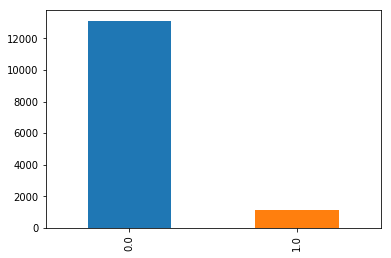

In [69]:
azdias['OST_WEST_KZ'] = convert_mixed(customers, 'OST_WEST_KZ')
plot_bar(azdias, 'OST_WEST_KZ')

Another column whose values will need to be converted to integers is the "D19_LETZTER_KAUF_BRANCHE" one. 

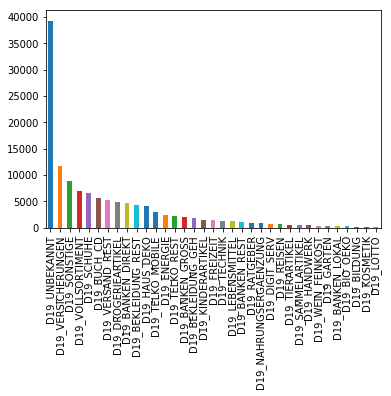

In [337]:
plot_bar(azdias, "D19_LETZTER_KAUF_BRANCHE")

In [70]:
azdias['D19_LETZTER_KAUF_BRANCHE'] = convert_mixed(azdias, 'D19_LETZTER_KAUF_BRANCHE')
customers['D19_LETZTER_KAUF_BRANCHE'] = convert_mixed(customers, 'D19_LETZTER_KAUF_BRANCHE')

And check to make sure the column values are integers now. 

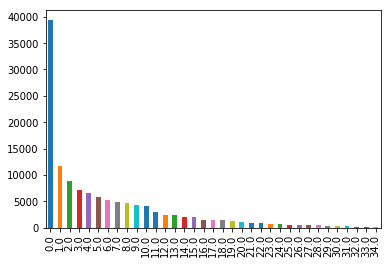

In [75]:
plot_bar(azdias, "D19_LETZTER_KAUF_BRANCHE")

This begs the questions, do any of the other columns with the D19 prefix also have categorical values. This will be looked at below. 

In [340]:
columns = azdias.columns
columns[26:94]

Index(['D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24

In [341]:
bank_cols = columns[26:94]

In [342]:
for col in bank_cols:
    print(azdias[col].unique())

[0 1 2 3 5 6 4]
[0 1 2 4 5 3 6]
[10  9  5  8  3  7  4  6  2  1]
[0 6 2 3 7 5 1 4]
[0 3 6 5 2 1 4]
[0 7 2 5 3 6 4 1]
[10  5  9  2  7  8  1  6  4  3]
[10  9  8  3  7  4  6  2  5  1]
[ nan   0.  10.   4.   5.   8.   3.   7.   6.   9.   2.]
[0 6 3 7 5 2 4 1]
[0 5 1 7 6 2 3 4]
[0 2 6 3 7 4 1 5]
[0 2 6 7 3 5 4 1]
[0 6 7 3 5 4 2]
[0 6 5 2 4 7 3 1]
[0 6 4 5 7 1 3 2]
[0 3 4 6 2 7 1 5]
[0 3 5 6 7 2 4 1]
[0 2 5 6 3 7 1 4]
[0 7 3 6 5 2 4 1]
[0 1 3 2 4 5 6]
[0 1 4 3 2 6 5]
[10  5  7  2  8  9  3  1  6  4]
[10  9  8  7  5  2  6  3  1  4]
[10  5  7  2  9  8  3  1  6  4]
[ nan  10.   0.   8.   6.   7.   9.   5.   3.   1.   2.   4.]
[0 6 7 5 3 4 2 1]
[0 6 5 3 7 4 1 2]
[0 6 5 2 7 3 4 1]
[ nan   3.   2.   5.   1.   9.   6.   4.]
[9 2 1 3 8 4]
[0 6 7 5 3 4 2 1]
[0 6 7 5 2 3 1 4]
[ nan   3.   7.  21.  10.   9.   2.   0.   6.  11.   8.   4.  15.  16.   1.
  17.  12.   5.  18.  20.  13.  14.  26.  33.  19.  30.  25.  28.  31.  23.
  29.  22.  24.  27.  32.  34.]
[ nan   0.   7.   5.   6.   3.   4.   1.   2.]


Fortunately the answer to the question is no. All the columns with the D19 prefix have integer values so they don't need to be engineered. 

Prior to re-sorting all of the columns, which could take a lot of time it would be wise to handle missing data first such as dropping columns and rows with too much missing data or replacing them with data in some way. The two functions below "fraction_missing" and also "percent_missing" provide some insight into this.  

In [71]:
def percent_missing(df):
    """
    Calulates the fraction of missing data for each column in a dataframe
    
    INPUT:
    - df: A dataframe
    
    OUTPUT:
    - df_missing: A series that includes the name of a column and the fraction of data it is missing.
    
    """
    df_missing = df.isnull().mean()*100
    df_missing = df_missing.sort_values(ascending = False)
    return df_missing

In [344]:
def fraction_missing(df):
    """
    A bar plot that shows the fraction of data missing on the horizontal axis and the number of columns that 
    are missing that fraction of data on the vertical axis
    
    INPUT:
    - df: A dataframe
    
    OUTPUT:
    - A bar plot showing the number of columns missing a giving fraction of data. 
    
    """
    df_missing = df.isnull().mean()
    plt.hist(df_missing, bins=40)
    plt.xlabel('Fraction of Data Missing in Azdias Dataframe')
    # naming the y axis
    plt.ylabel('Number of Columns')

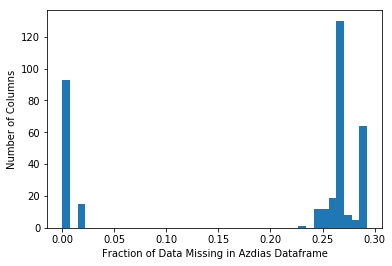

In [107]:
fraction_missing(customers)

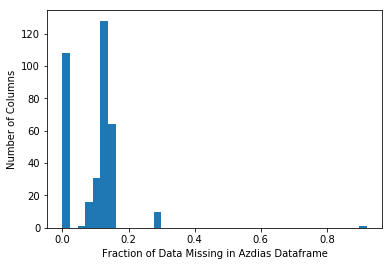

In [108]:
fraction_missing(azdias)

In [345]:
percent_missing(azdias)[1:20]

ALTER_KIND3                    99.337425
ALTER_KIND2                    96.780256
OST_WEST_KZ                    92.006463
ALTER_KIND1                    90.945558
AGER_TYP                       75.961042
EXTSEL992                      73.443706
KK_KUNDENTYP                   65.626332
ALTERSKATEGORIE_FEIN           29.475887
D19_LETZTER_KAUF_BRANCHE       28.862122
D19_LOTTO                      28.862122
D19_VERSI_ONLINE_QUOTE_12      28.862122
D19_BANKEN_ONLINE_QUOTE_12     28.862122
D19_GESAMT_ONLINE_QUOTE_12     28.862122
D19_TELKO_ONLINE_QUOTE_12      28.862122
D19_VERSAND_ONLINE_QUOTE_12    28.862122
D19_SOZIALES                   28.862122
D19_KONSUMTYP                  28.862122
KBA05_KRSVAN                   14.980027
KBA05_KRSZUL                   14.980027
dtype: float64

In [346]:
percent_missing(customers)[1:20]

ALTER_KIND3      99.317513
ALTER_KIND2      97.271096
ALTER_KIND1      93.884749
KK_KUNDENTYP     58.227412
AGER_TYP         48.139336
EXTSEL992        44.474360
KBA05_KW3        29.122576
KBA05_SEG6       29.122576
KBA05_SEG7       29.122576
KBA05_SEG8       29.122576
KBA05_VORB0      29.122576
KBA05_SEG9       29.122576
KBA05_SEG4       29.122576
KBA05_VORB1      29.122576
KBA05_KW1        29.122576
KBA05_KRSZUL     29.122576
KBA05_KRSVAN     29.122576
KBA05_KRSOBER    29.122576
KBA05_SEG5       29.122576
dtype: float64

There is another column of customer information called 'GEBURTSJAHR'. It is the birthyear of the customer. It is categorical although not identified as being such in the earlier steps. A bar plot shows the distribution.

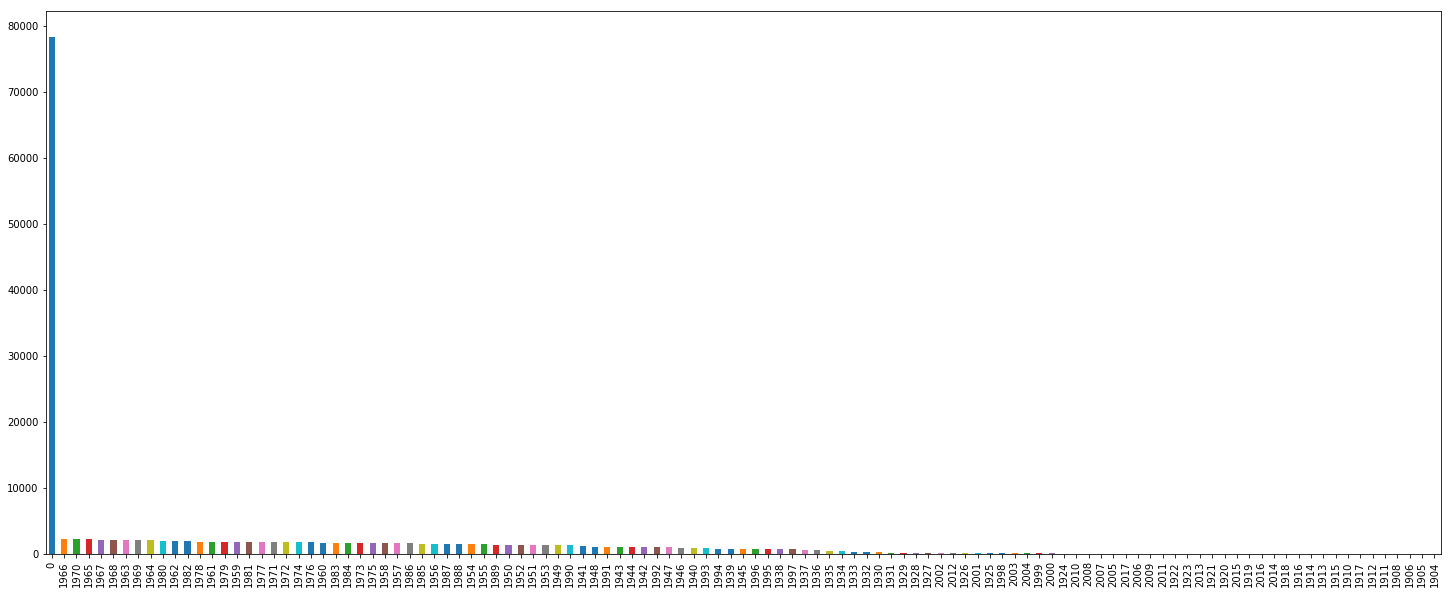

In [347]:
plt.figure(figsize=(25, 10))
plot_bar(azdias, 'GEBURTSJAHR')

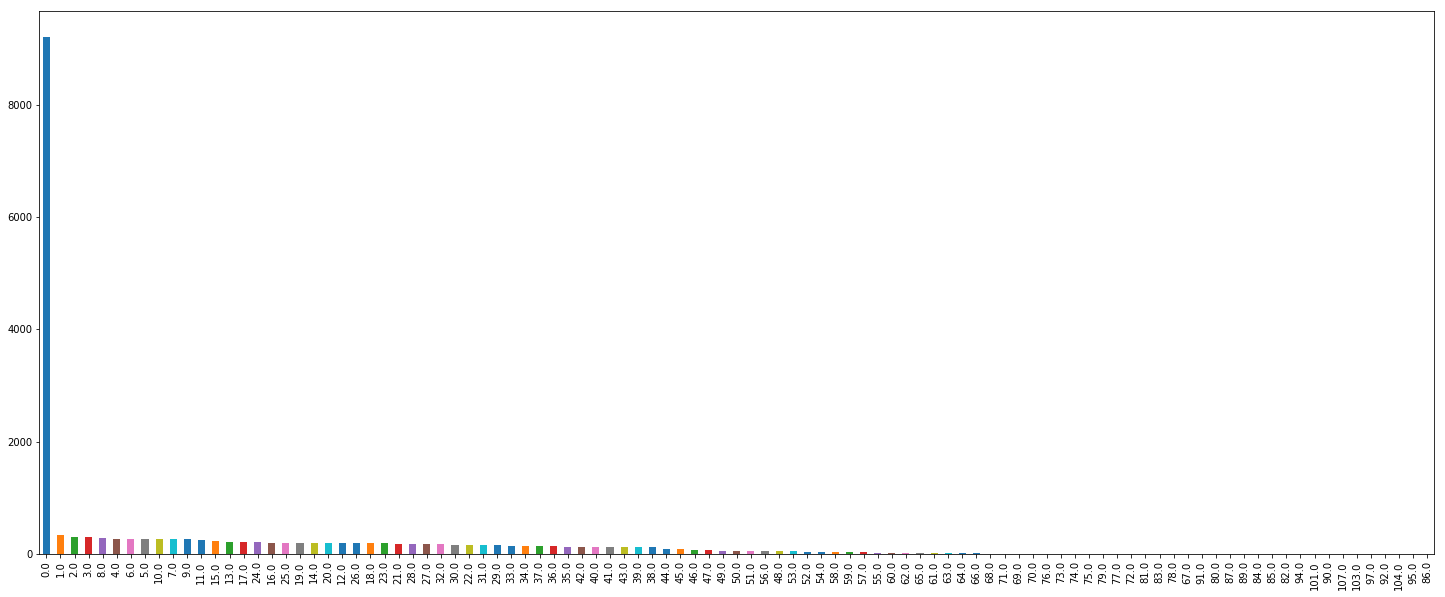

In [348]:
plt.figure(figsize=(25, 10))
azdias['GEBURTSJAHR'] = convert_mixed(customers, 'GEBURTSJAHR')
plot_bar(azdias, 'GEBURTSJAHR')

This columns looks to be dominated by the value of 0, which means 89% of the rows are missing this value. For this reason, drop it from the 'data sets'! 

In [349]:
azdias['GEBURTSJAHR'].isnull().mean()

0.89227126859810146

In [72]:
azdias = azdias.drop(['GEBURTSJAHR'], axis =1)
customers = customers.drop(['GEBURTSJAHR'], axis =1)

The columns with the most missing data will be inspected now.

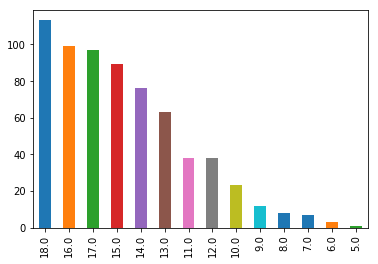

In [90]:
plot_bar(customers, 'ALTER_KIND3')

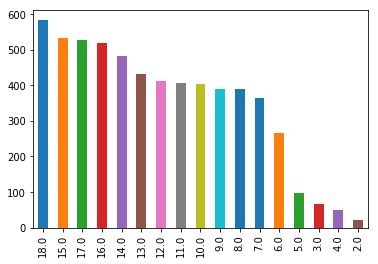

In [111]:
plot_bar(customers, 'ALTER_KIND1')

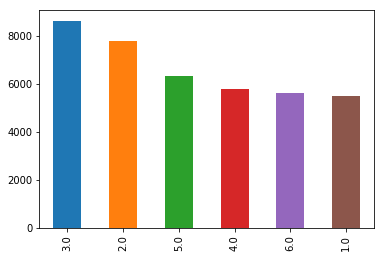

In [112]:
plot_bar(customers, 'KK_KUNDENTYP')

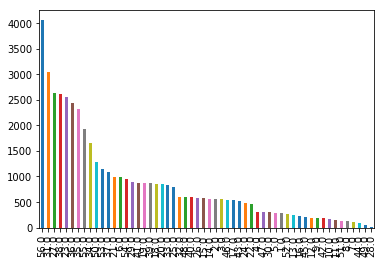

In [113]:
plot_bar(azdias, 'EXTSEL992')

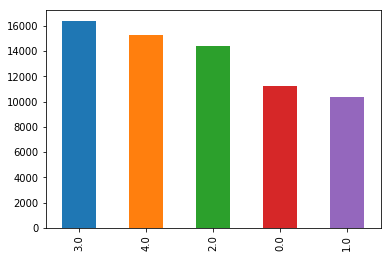

In [114]:
plot_bar(customers, 'KBA05_ANTG1')

The data for these columns 'ALTER_KIND', 'KK_KUDENTYPE', and 'EXTSEL992' look linear more or less but they have a lot of their data missing. It is probably better to just delete them from the dataframes.

In [73]:
customers = customers.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP'], axis = 1)
azdias = azdias.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'], axis = 1)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
176465,18214,2.0,5.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,...,0.0,3,2,4,2010.0,19.0,1.0,4.0,1,0
183496,87600,2.0,1.0,19.0,10.0,4.0,0.0,0.0,5.0,6.0,...,7.0,3,1,3,1992.0,32.0,4.0,3.0,1,0
108099,172050,NaN,1.0,14.0,0.0,1.0,0.0,0.0,4.0,1.0,...,3.0,1,1,4,1992.0,38.0,5.0,4.0,2,0
132970,66654,NaN,1.0,0.0,14.0,4.0,0.0,0.0,3.0,5.0,...,1.0,1,1,4,1992.0,32.0,4.0,3.0,3,1
2253,166710,1.0,2.0,9.0,9.0,14.0,1.0,0.0,1.0,14.0,...,3.0,6,2,1,1992.0,9.0,5.0,1.0,1,1


So, both data frames are missing a lot of data with the 'KBA05' prefix. 15% for 'azdias' and 29.4% for 'customers'. The 'azdias' frame is also missing a lot of data with the 'D19' prefix. 

In [352]:
percent_missing(customers)[0:20]

AGER_TYP          48.139336
KBA05_SEG2        29.122576
KBA05_MAXBJ       29.122576
KBA05_VORB0       29.122576
KBA05_VORB1       29.122576
KBA05_VORB2       29.122576
KBA05_ZUL1        29.122576
KBA05_ZUL2        29.122576
KBA05_MAXHERST    29.122576
KBA05_MAXAH       29.122576
KBA05_SEG8        29.122576
KBA05_KW3         29.122576
KBA05_KW2         29.122576
KBA05_KW1         29.122576
KBA05_KRSZUL      29.122576
KBA05_KRSVAN      29.122576
KBA05_SEG9        29.122576
KBA05_MAXSEG      29.122576
KBA05_SEG6        29.122576
KBA05_MAXVORB     29.122576
dtype: float64

In [353]:
percent_missing(azdias)[0:20]

OST_WEST_KZ                    92.006463
AGER_TYP                       75.961042
ALTERSKATEGORIE_FEIN           29.475887
D19_LOTTO                      28.862122
D19_TELKO_ONLINE_QUOTE_12      28.862122
D19_BANKEN_ONLINE_QUOTE_12     28.862122
D19_VERSAND_ONLINE_QUOTE_12    28.862122
D19_VERSI_ONLINE_QUOTE_12      28.862122
D19_GESAMT_ONLINE_QUOTE_12     28.862122
D19_KONSUMTYP                  28.862122
D19_SOZIALES                   28.862122
D19_LETZTER_KAUF_BRANCHE       28.862122
KBA05_MAXBJ                    14.980027
KBA05_MOD4                     14.980027
KBA05_MOD3                     14.980027
KBA05_MOD2                     14.980027
KBA05_MAXVORB                  14.980027
KBA05_MAXSEG                   14.980027
KBA05_MAXHERST                 14.980027
KBA05_KRSZUL                   14.980027
dtype: float64

So, looking at the remaining missing data it shows 'OST_WEST_KZ' has most if its data missing, 92%. 'AGER_TYPE' has too much missing as well, 75%. 'ALTERSKATEGORIE_FEIN', and a few columns with prefix 'D19' have over 29% of their data missing. This will be dealt with by dropping the 'ALTERSKATEGORIE_FEIN', and 'OST_WEST_KZ' because too much is missing and there is an 'ALTERSKATEGORIE_GROB' column that should suffice to preserve this data. What this data even means can be looked at by looking it up in the 'feature_values' data set. 

In [121]:
feature_values[feature_values['Attribute'] == 'ALTERSKATEGORIE_GROB']

,Attribute,Description,Value,Meaning
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years
10,ALTERSKATEGORIE_GROB,age classification through prename analysis,9,uniformly distributed


So, apparently it is dealing with age classification. 

In [74]:
customers = customers.drop(['OST_WEST_KZ', 'AGER_TYP' ], axis = 1)

In [75]:
azdias = azdias.drop(['OST_WEST_KZ', 'AGER_TYP'], axis = 1)
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
395430,777255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3,1,2,NaN,NaN,NaN,NaN,1,0
620626,298340,1.0,17.0,17.0,4.0,0.0,2.0,1.0,4.0,0.0,...,7.0,4,2,1,1996.0,22.0,3.0,3.0,5,0
376138,914305,1.0,16.0,16.0,1.0,0.0,0.0,3.0,1.0,0.0,...,7.0,1,1,3,1996.0,33.0,2.0,4.0,4,1
229799,1015208,9.0,16.0,NaN,9.0,0.0,0.0,7.0,10.0,0.0,...,4.0,3,2,1,1992.0,29.0,5.0,4.0,5,0
594744,271589,9.0,16.0,NaN,2.0,0.0,0.0,1.0,1.0,0.0,...,2.0,3,2,4,2006.0,12.0,2.0,4.0,1,0


In [357]:
percent_missing(customers)[1:20]

KBA05_SEG2        29.122576
KBA05_MAXBJ       29.122576
KBA05_VORB0       29.122576
KBA05_VORB1       29.122576
KBA05_VORB2       29.122576
KBA05_ZUL1        29.122576
KBA05_ZUL2        29.122576
KBA05_MAXHERST    29.122576
KBA05_MAXAH       29.122576
KBA05_SEG8        29.122576
KBA05_KW3         29.122576
KBA05_KW2         29.122576
KBA05_KW1         29.122576
KBA05_KRSZUL      29.122576
KBA05_KRSVAN      29.122576
KBA05_SEG9        29.122576
KBA05_MAXSEG      29.122576
KBA05_SEG6        29.122576
KBA05_MAXVORB     29.122576
dtype: float64

In [362]:
percent_missing(azdias)[1:20]

D19_LOTTO                      28.862122
D19_TELKO_ONLINE_QUOTE_12      28.862122
D19_BANKEN_ONLINE_QUOTE_12     28.862122
D19_VERSAND_ONLINE_QUOTE_12    28.862122
D19_VERSI_ONLINE_QUOTE_12      28.862122
D19_GESAMT_ONLINE_QUOTE_12     28.862122
D19_KONSUMTYP                  28.862122
D19_SOZIALES                   28.862122
D19_LETZTER_KAUF_BRANCHE       28.862122
KBA05_MAXHERST                 14.980027
KBA05_MOTOR                    14.980027
KBA05_MOD8                     14.980027
KBA05_MOD4                     14.980027
KBA05_MOD3                     14.980027
KBA05_MOD1                     14.980027
KBA05_MAXVORB                  14.980027
KBA05_MAXSEG                   14.980027
KBA05_KW1                      14.980027
KBA05_MAXBJ                    14.980027
dtype: float64

So, how should the remainding missing data be dealt with. A more advanced technique can usaully improve the models performance in predictive analytics. One such method is to impute the data based on what what the most common value is for a given categorical group but that won't work here because alot of those values are missing too. Therefore, the rest of the missing data will be imputed with the median value for each column with missing data in it. 

In [76]:
for col in customers.columns:   
    customers.fillna(customers[col].median(), inplace = True)

In [77]:
for col in azdias.columns:   
    azdias.fillna(azdias[col].median(), inplace = True)

In [78]:
percent_missing(customers)[0:5]

MOVEMENT           0.0
KBA05_HERSTTEMP    0.0
KBA05_ALTER4       0.0
KBA05_ANHANG       0.0
KBA05_ANTG1        0.0
dtype: float64

In [79]:
percent_missing(azdias)[0:5]

MOVEMENT           0.0
KBA05_HERSTTEMP    0.0
KBA05_ALTER4       0.0
KBA05_ANHANG       0.0
KBA05_ANTG1        0.0
dtype: float64

So, the missing data has been dealt with now. 

In [367]:
pickle_out = open("customers2.pickle","wb")
pickle.dump(customers, pickle_out)
pickle_out.close()

In [368]:
pickle_out = open("azdias2.pickle","wb")
pickle.dump(azdias, pickle_out)
pickle_out.close()

In [9]:
pickle_in = open("customers2.pickle","rb")
customers = pickle.load(pickle_in)

In [10]:
pickle_in = open("azdias2.pickle","rb")
azdias = pickle.load(pickle_in)

In [36]:
customers.shape

(95826, 359)

In [37]:
azdias.shape

(178244, 357)

The next course of action is to make sure all the columns are numerical before analyzing them with the unsupervised and supervised learning models. 

In [38]:
numerical_df = azdias.select_dtypes(exclude=['object'])
customers_numerical_df = customers.select_dtypes(exclude=['object'])

In [39]:
numerical_df.shape

(178244, 357)

In [40]:
azdias.shape

(178244, 357)

In [41]:
customers.shape

(95826, 359)

In [42]:
customers_numerical_df.shape

(95826, 359)

In [82]:
extra_columns_customers = [col for col in customers.columns if col not in azdias.columns]
extra_columns_customers

[]

In [10]:
azdias_category_df = azdias.select_dtypes(include=['object'])
customers_category_df = customers.select_dtypes(include=['object'])

In [12]:
azdias_category_df.head()

""
395430
620626
376138
229799
594744


In [15]:
azdias.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

Its a bit strange that it says there are 359 columns, 357 are numerical, but no non-numerical columns can be located. Hopefully this issue doesn't come to haunt. 

So, at last the data pre-processing looks to be complete. All of the data is numerical as well. 

## EVALUATION I. UNSUPERVISED MODEL (Clustering)

Now that the data in the dataframes has been pre-processed it can evaluated in order to achieve the desired result of segmenting the customers into clusters and then determining which of the cluster(s) contain data the yield likely customers for the company. After the clustering is complete a classification model will be chosen based on how well predicts if an indidual will become a customer for the company  by testing the performance on the 'training data set'. Lastly the classification model will be used on a 'test set' of data and the results will be submitted to a Kaggle competition. 

Firstly the dataframes are 'normalized' to get two dataframes 'azdias_normalized', and 'customers_normalized'. Next, the columns with the highest variance are selected using PCA (Principal Component Analysis) and the dataframes are reduced in size based on the desired total variance. 88.9% was the target for total variance, this means 88.9% of the mathematical information is retained. After that the reduced in size dataframes will be used for cluster analysis. 

In [83]:
x = azdias.values
x = StandardScaler().fit_transform(x) # normalizing the features

In [380]:
x2 = customers.values
x2 = StandardScaler().fit_transform(x2) # normalizing the features

In [11]:
all_columns = customers.columns

In [382]:
azdias_normalized = pd.DataFrame(x, columns= all_columns)

In [383]:
customers_normalized = pd.DataFrame(x2, columns= all_columns)

In [384]:
azdias_normalized.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
0,0.543696,3.316584,3.316584,1.546804,2.919175,2.851553,3.316584,3.316584,2.919175,3.316584,...,2.919175,-0.271300,-1.037133,-0.728517,2.919175,2.838830,2.811834,2.811834,-1.308205,-0.492662
1,-1.318236,-0.301535,-0.301480,-0.646483,-0.342584,-0.350686,-0.301505,-0.301519,-0.342581,-0.301515,...,-0.342547,0.467989,0.964196,-1.666367,-0.342551,-0.352229,-0.355641,-0.355639,1.247231,-0.492662
2,1.076521,-0.301535,-0.301486,-0.646486,-0.342600,-0.350686,-0.301516,-0.301508,-0.342596,-0.301515,...,-0.342547,-1.749878,-1.037133,0.209333,-0.342551,-0.352174,-0.355646,-0.355634,0.608372,2.029789
3,1.468813,-0.301489,-0.301486,1.546804,-0.342559,-0.350686,-0.301516,-0.301485,-0.342550,-0.301515,...,-0.342563,-0.271300,0.964196,-1.666367,-0.342572,-0.352194,-0.355631,-0.355634,1.247231,-0.492662
4,-1.422239,-0.301489,-0.301486,1.546804,-0.342594,-0.350686,-0.301516,-0.301519,-0.342596,-0.301515,...,-0.342573,-0.271300,0.964196,1.147183,-0.342500,-0.352279,-0.355646,-0.355634,-1.308205,-0.492662


In [385]:
customers_normalized.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
0,-1.410612,-0.565984,-0.566095,-0.608026,-0.592413,-0.609872,-0.566066,-0.566069,-0.592406,-0.566063,...,-0.592407,0.359544,1.291217,0.865327,-0.591920,-0.600983,-0.597598,-0.597545,-0.541654,-0.762661
1,-0.154482,-0.566081,-0.565876,-0.608026,-0.592342,-0.609872,-0.566066,-0.565996,-0.592288,-0.566063,...,-0.592241,0.359544,-0.774463,-0.055872,-0.592356,-0.600677,-0.597527,-0.597569,-0.541654,-0.762661
2,1.374361,-0.566081,-0.565998,-0.608261,-0.592413,-0.609872,-0.566066,-0.566020,-0.592406,-0.566063,...,-0.592336,-1.347943,-0.774463,0.865327,-0.592356,-0.600536,-0.597503,-0.597545,0.271272,-0.762661
3,-0.533678,-0.566081,-0.566337,-0.607933,-0.592342,-0.609872,-0.566066,-0.566045,-0.592312,-0.566063,...,-0.592383,-1.347943,-0.774463,0.865327,-0.592356,-0.600677,-0.597527,-0.597569,1.084199,1.311198
4,1.277688,-0.566056,-0.566119,-0.608050,-0.592104,-0.609848,-0.566066,-0.566093,-0.592098,-0.566039,...,-0.592336,2.920775,1.291217,-1.898270,-0.592356,-0.601219,-0.597503,-0.597616,-0.541654,1.311198


In [386]:
pickle_out = open("azdias_normalized.pickle","wb")
pickle.dump(azdias_normalized, pickle_out)
pickle_out.close()

In [387]:
pickle_out = open("customers_normalized.pickle","wb")
pickle.dump(customers_normalized, pickle_out)
pickle_out.close()

In [80]:
pickle_in = open("azdias_normalized.pickle","rb")
azdias_normalized = pickle.load(pickle_in)

In [81]:
pickle_in = open("customers_normalized.pickle","rb")
customers_normalized = pickle.load(pickle_in)

In [94]:
from sklearn.decomposition import PCA
pca_azdias = PCA(n_components = 75)
principalComponents_azdias = pca_azdias.fit_transform(azdias_normalized)

In [414]:
principalComponents_customers = pca_azdias.fit_transform(customers_normalized)

In [415]:
#principalComponents_azdias

In [100]:
feat_cols = ['P.C. '+str(i) for i in range(75)]

In [417]:
principal_azdias_Df = pd.DataFrame(data = principalComponents_azdias, columns = feat_cols)

In [418]:
principal_customers_Df = pd.DataFrame(data = principalComponents_customers, columns = feat_cols)

In [419]:
pickle_out = open("principal_azdias_Df.pickle","wb")
pickle.dump(principal_azdias_Df, pickle_out)
pickle_out.close()

In [420]:
pickle_out = open("principal_customers_Df.pickle","wb")
pickle.dump(principal_customers_Df, pickle_out)
pickle_out.close()

In [82]:
pickle_in = open("principal_customers_Df.pickle","rb")
principal_customers_Df = pickle.load(pickle_in)

In [83]:
pickle_in = open("principal_azdias_Df.pickle","rb")
principal_azdias_Df = pickle.load(pickle_in)

In [421]:
principal_azdias_Df.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 65,P.C. 66,P.C. 67,P.C. 68,P.C. 69,P.C. 70,P.C. 71,P.C. 72,P.C. 73,P.C. 74
0,42.409207,-2.909707,0.815558,0.339666,1.620454,-4.043603,-1.698359,-1.010223,0.156980,1.131962,...,0.174270,-0.178613,0.083910,-0.127728,0.106505,0.013346,0.010302,-0.048639,0.041151,0.308894
1,-5.860644,-0.611058,-0.423720,-0.161790,3.590851,1.584286,2.177387,-2.719701,-0.001342,-0.249540,...,0.315328,0.326972,-0.841434,0.869247,-0.430565,0.236952,0.495721,0.095061,0.080322,0.027671
2,-6.224094,1.547484,0.108102,-1.617186,-0.557710,0.431011,-2.339126,-0.886609,-0.747763,-0.260303,...,0.215541,1.138884,-1.105237,0.021354,0.123042,-0.294157,0.788200,0.142231,0.323041,0.128334
3,-5.860541,0.130149,-0.217732,-0.793255,3.569531,0.461223,3.065998,-2.586457,-1.060080,-0.257255,...,-0.991951,-0.793735,-1.607500,-0.005246,0.470332,-0.613703,0.010837,0.045642,0.001142,0.516176
4,5.928977,6.604409,-4.777739,17.048689,-4.021914,0.011985,1.941247,3.969260,0.132829,1.079114,...,-1.108226,0.174321,0.031069,0.039691,-0.475126,-0.842572,-0.173846,-0.381321,0.063443,0.751509


In [422]:
principal_azdias_Df.shape

(178244, 75)

In [96]:
principal_customers_Df.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 65,P.C. 66,P.C. 67,P.C. 68,P.C. 69,P.C. 70,P.C. 71,P.C. 72,P.C. 73,P.C. 74
0,0.105096,-1.532125,5.416494,13.390628,-4.502815,1.185108,0.773938,-1.905531,1.499065,3.181193,...,-0.192735,1.070400,-1.737620,-1.113249,4.293519,-0.208344,-0.081902,0.725241,0.167672,-0.331310
1,-10.379537,-0.862726,1.685607,-0.857239,1.185181,0.020218,-3.012861,-1.034358,0.327310,-0.517504,...,0.361953,-0.116883,-0.177703,0.050973,0.003186,-0.420371,0.188400,0.191430,-0.188475,-0.620886
2,-10.766906,-0.935037,3.074910,-1.005474,1.312719,-0.589104,-1.492895,-0.051277,0.569111,-2.298819,...,-0.528904,-0.630240,-0.103041,0.088846,-0.002919,0.146107,-0.509969,0.456976,0.059526,-0.456900
3,-9.951807,-0.599776,-0.321111,-0.232315,0.930083,-1.869858,-1.569356,1.213103,0.282884,-1.889323,...,-0.441975,-0.412135,0.274481,-0.176345,0.085983,0.295142,0.292249,0.315581,-0.507492,0.226199
4,-8.789337,-0.391990,-2.887508,-0.686596,-3.150865,1.498433,-1.236575,0.016859,-0.234934,0.071561,...,-0.665258,-0.149026,0.695176,-0.272807,0.191136,1.032600,-0.649023,0.032009,-0.991961,-1.148432


Next order of business is to make a data frame that shows the variance of the PCA. 

In [97]:
explained_variance = pca_azdias.explained_variance_ratio_

In [98]:
cumulative_variance = np.cumsum(np.round(explained_variance, decimals = 3))

In [101]:
pca_df = pd.DataFrame(feat_cols, columns = ['PC'])

In [102]:
explained_variance_df = pd.DataFrame(explained_variance, columns = ['Explained Variance'])

In [103]:
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns = ['Cumulative Variance'])

In [104]:
df_explained_variance = pd.concat([pca_df, explained_variance_df, cumulative_variance_df], axis = 1)

In [105]:
df_explained_variance.head(15)

,PC,Explained Variance,Cumulative Variance
0,P.C. 0,0.606706,0.607
1,P.C. 1,0.056404,0.663
2,P.C. 2,0.040475,0.703
3,P.C. 3,0.040269,0.743
4,P.C. 4,0.024105,0.767
5,P.C. 5,0.021114,0.788
6,P.C. 6,0.015815,0.804
7,P.C. 7,0.012498,0.816
8,P.C. 8,0.009360,0.825
9,P.C. 9,0.007581,0.833


In [106]:
df_explained_variance.tail(10)

,PC,Explained Variance,Cumulative Variance
65,P.C. 65,0.001266,0.979
66,P.C. 66,0.001188,0.980
67,P.C. 67,0.001126,0.981
68,P.C. 68,0.000971,0.982
69,P.C. 69,0.000907,0.983
70,P.C. 70,0.000861,0.984
71,P.C. 71,0.000792,0.985
72,P.C. 72,0.000768,0.986
73,P.C. 73,0.000756,0.987
74,P.C. 74,0.000743,0.988


Next, create visualization of how the variance increases along with the number of PC's! 

In [432]:
pc_num = []
for i in range(75):
    pc_num.append(i)

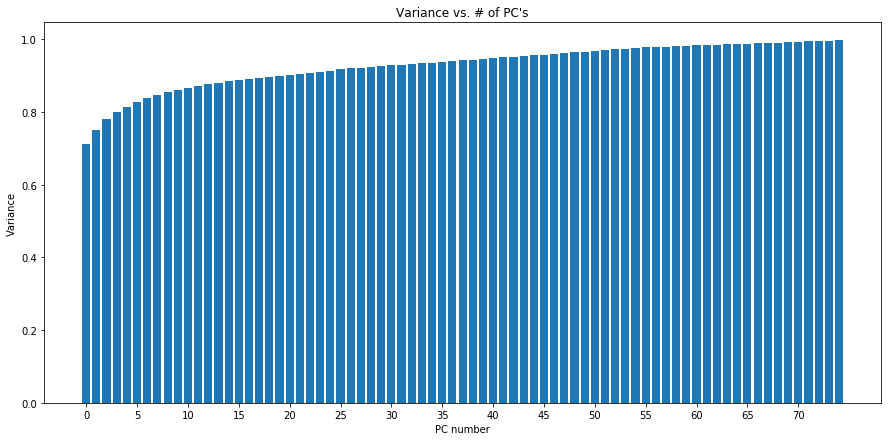

In [434]:
plt.figure(figsize=(15,7))
plt.bar(pc_num, cumulative_variance)
plt.xticks(np.arange(0, 75, 5))
plt.xlabel('PC number')
# naming the y axis
plt.ylabel('Variance')
plt.title("Variance vs. # of PC's")
plt.show()

So, having 75 PC's retains 99.7% of the variance.

It would be desirable to know what are the most and least dominating numerical columns of the original data frame for each principle component. This can be ascertained using .components_ method:

In [111]:
pca_relevance = pca_azdias.components_
pca_relevance.shape

(75, 357)

In [112]:
type(pca_relevance)

numpy.ndarray

So, now the pca_relevance numpy array provides the information as to what the weight is of each numerical column for the respective principal component. Convert the numpy array to a data frame so its easier to work with!

In [84]:
all_columns = customers_normalized.columns

In [121]:
all_columns = list(all_columns)

In [122]:
len(all_columns)

357

In [123]:
pc_relevance = pd.DataFrame(pca_relevance, columns = all_columns)

In [124]:
pc_relevance.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
0,0.000292,0.058724,0.058724,0.028927,0.065004,0.063642,0.058724,0.058724,0.065004,0.058724,...,0.065004,-0.003213,0.000468,-0.007596,0.065004,0.030638,0.063878,0.063878,-0.024639,-0.011551
1,-0.000633,-0.039445,-0.039440,-0.085663,-0.013787,-0.014270,-0.039443,-0.039442,-0.013787,-0.039443,...,-0.013784,-0.045425,-0.007500,-0.003355,-0.013782,-0.051461,-0.012267,-0.012266,0.041335,0.042748
2,0.001498,0.006654,0.006655,-0.015023,0.004690,0.004764,0.006654,0.006654,0.004690,0.006654,...,0.004690,-0.011654,-0.000470,0.006031,0.004689,0.069680,0.004461,0.004461,-0.007487,0.011163
3,0.003687,0.002420,0.002417,0.045617,-0.017233,-0.015490,0.002419,0.002418,-0.017233,0.002419,...,-0.017233,0.023995,0.003224,-0.004689,-0.017231,0.040260,-0.018604,-0.018604,-0.003403,-0.031234
4,0.005877,0.044071,0.044072,0.045827,0.009313,0.006153,0.044070,0.044070,0.009313,0.044070,...,0.009312,0.070767,-0.030698,-0.253394,0.009312,0.042526,0.005579,0.005579,0.210656,-0.040278


So, this looks really good because now the data frame 'pc_relevance' informs what the columns weights are for each principle component. The principle component is the row in this data frame. 

In [125]:
pickle_out = open("pc_relevance","wb")
pickle.dump(pc_relevance, pickle_out)
pickle_out.close()

In [85]:
pickle_in = open("pc_relevance","rb")
pc_relevance = pickle.load(pickle_in)

In [127]:
pc_relevance.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
0,0.000292,0.058724,0.058724,0.028927,0.065004,0.063642,0.058724,0.058724,0.065004,0.058724,...,0.065004,-0.003213,0.000468,-0.007596,0.065004,0.030638,0.063878,0.063878,-0.024639,-0.011551
1,-0.000633,-0.039445,-0.039440,-0.085663,-0.013787,-0.014270,-0.039443,-0.039442,-0.013787,-0.039443,...,-0.013784,-0.045425,-0.007500,-0.003355,-0.013782,-0.051461,-0.012267,-0.012266,0.041335,0.042748
2,0.001498,0.006654,0.006655,-0.015023,0.004690,0.004764,0.006654,0.006654,0.004690,0.006654,...,0.004690,-0.011654,-0.000470,0.006031,0.004689,0.069680,0.004461,0.004461,-0.007487,0.011163
3,0.003687,0.002420,0.002417,0.045617,-0.017233,-0.015490,0.002419,0.002418,-0.017233,0.002419,...,-0.017233,0.023995,0.003224,-0.004689,-0.017231,0.040260,-0.018604,-0.018604,-0.003403,-0.031234
4,0.005877,0.044071,0.044072,0.045827,0.009313,0.006153,0.044070,0.044070,0.009313,0.044070,...,0.009312,0.070767,-0.030698,-0.253394,0.009312,0.042526,0.005579,0.005579,0.210656,-0.040278


In [128]:
comp_0 = pc_relevance.iloc[0]

In [129]:
comp_0[1:20]

AKT_DAT_KL                    0.058724
ALTER_HH                      0.058724
ALTERSKATEGORIE_FEIN          0.028927
ANZ_HAUSHALTE_AKTIV           0.065004
ANZ_HH_TITEL                  0.063642
ANZ_KINDER                    0.058724
ANZ_PERSONEN                  0.058724
ANZ_STATISTISCHE_HAUSHALTE    0.065004
ANZ_TITEL                     0.058724
ARBEIT                        0.063455
BALLRAUM                      0.064776
CAMEO_DEUG_2015               0.063878
CJT_GESAMTTYP                -0.001189
CJT_KATALOGNUTZER            -0.001189
CJT_TYP_1                    -0.001189
CJT_TYP_2                    -0.001189
CJT_TYP_3                    -0.001189
CJT_TYP_4                    -0.001189
CJT_TYP_5                    -0.001189
Name: 0, dtype: float64

In the next step a function will be created that gives the 10 most and 7 least relevant columns of a given principle component through a bar graph and explains what each means:

In [86]:
def relevant_columns(pc):
    """
    Takes the n'th principle component as an input and outputs information about the customers 
    including the top five most pertinent and least pertinent columns and their descriptions if one is available
    
    INPUT:
    - pc: The principal component from the PCA step
    
    OUTPUT:
    - component_info: Provides the feature, description of the feature, and variance for that feature for the pc input
    
    """
    descriptions = []
    descriptions_parsed = []

    
    pc_info = list(zip(pc_relevance.iloc[pc], all_columns))
    pc_info.sort()
    most_important = pc_info[-10:]
    most_important.sort(reverse = True)
    least_important = pc_info[0:7]
    least_important.sort(reverse = True)
    full_list = most_important + least_important
    unzipped_full = list(zip(*full_list))
    full_vals = unzipped_full[0]
    full_col_names = unzipped_full[1]
    plt.figure(figsize=(25,7))
    #plt.bar(most_important_col_names, most_important_vals)
    s = pd.Series(full_vals, index = full_col_names)
    s.plot(kind='bar',rot=0, title = "PC Variance of a Column vs. Column Name")
    plt.xlabel('Column Name')
    plt.ylabel('Variance')
    
    for name in full_col_names:
        description = feature_values[feature_values['Attribute'] == name]['Description'][0:1]
        descriptions.append(str(description))
    for desc in descriptions:
        descriptions2 = desc.split("\nName")[0][4:]
        descriptions_parsed.append(descriptions2)
    component_info = {"Feature":full_col_names, "Description":descriptions_parsed, "Variance": full_vals}
    component_info = pd.DataFrame(component_info)
    component_info
    
    component_info['Description'].replace('es([], Name: Description, dtype: object)', 'Unknown description', inplace=True)

    return component_info

,Feature,Description,Variance
0,KBA13_ANZAHL_PKW,number of cars in the PLZ8,0.066483
1,KBA13_AUTOQUOTE,share of cars per household within the PLZ8,0.066483
2,KBA13_CCM_3001,share of cars with more than 3000ccm withi...,0.066483
3,KBA13_GBZ,Unknown description,0.066483
4,KBA13_CCM_1500,share of cars with 1400ccm to 1499ccm with...,0.066483
5,KBA13_KRSAQUOT,share of cars per household (referred to t...,0.066483
6,KBA13_KMH_140,share of cars with max speed between 110 k...,0.066483
7,KBA13_HALTER_50,share of car owners between 46 and 50 with...,0.066483
8,KBA13_SITZE_6,number of cars with more than 5 seats in t...,0.066483
9,KBA13_SEG_GROSSRAUMVANS,share of big sized vans within the PLZ8,0.066483


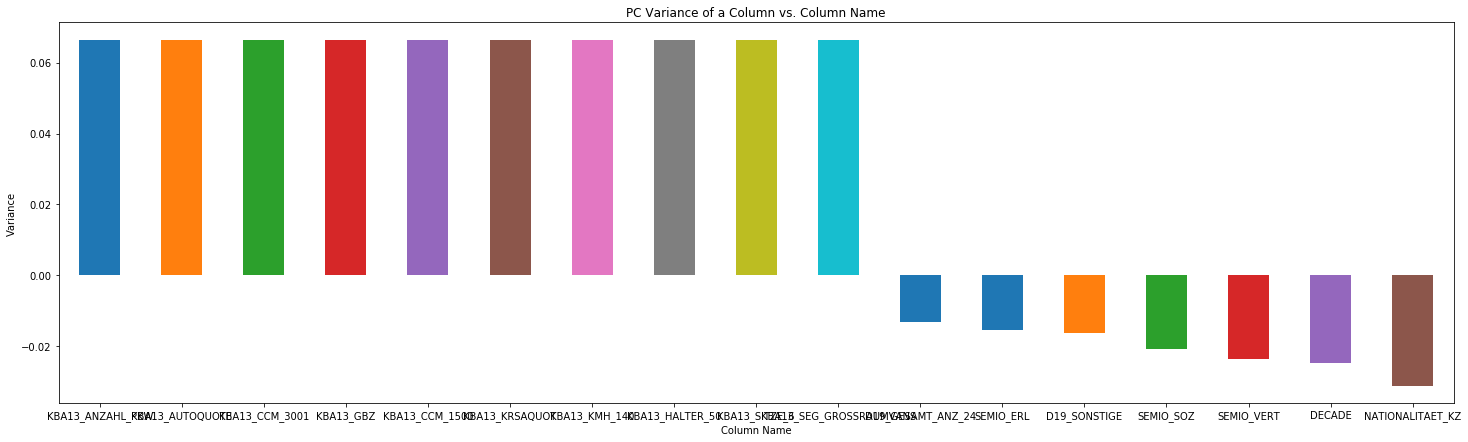

In [134]:
relevant_columns(0)

,Feature,Description,Variance
0,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last...,0.157679
1,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last...,0.145770
2,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last...,0.145422
3,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last...,0.132264
4,D19_HAUS_DEKO,Unknown description,0.096160
5,D19_VOLLSORTIMENT,Unknown description,0.090811
6,D19_BEKLEIDUNG_REST,Unknown description,0.090274
7,D19_VERSAND_REST,Unknown description,0.089670
8,D19_VERSICHERUNGEN,Unknown description,0.088916
9,D19_BUCH_CD,Unknown description,0.088316


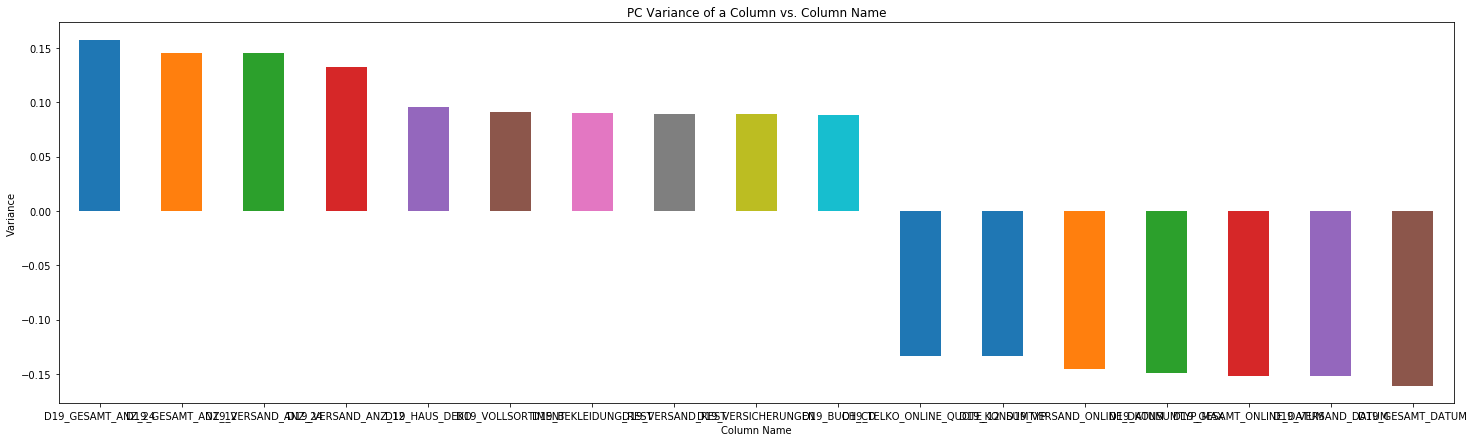

In [135]:
relevant_columns(1)

,Feature,Description,Variance
0,ONLINE_AFFINITAET,online affinity,0.253984
1,CJT_TYP_3,Unknown description,0.253984
2,CJT_GESAMTTYP,customer journey typology,0.253984
3,CJT_TYP_6,Unknown description,0.253984
4,CJT_TYP_4,Unknown description,0.253984
5,CJT_TYP_5,Unknown description,0.253984
6,LP_STATUS_GROB,social status rough,0.253984
7,CJT_TYP_1,Unknown description,0.253984
8,CJT_TYP_2,Unknown description,0.253984
9,RT_SCHNAEPPCHEN,Unknown description,0.253984


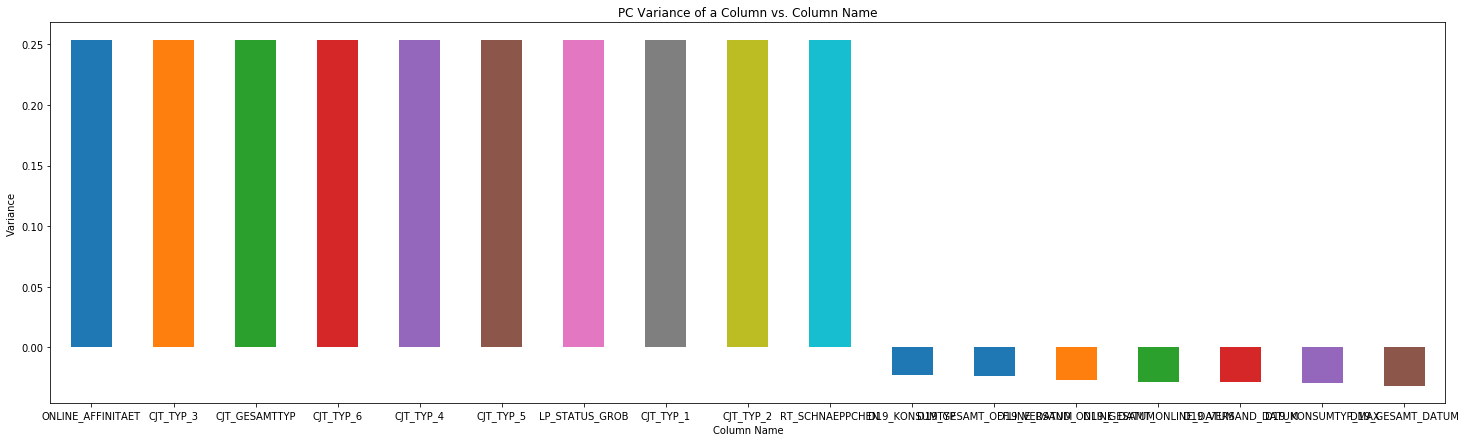

In [136]:
relevant_columns(2)

,Feature,Description,Variance
0,D19_GESAMT_DATUM,actuality of the last transaction with the ...,0.099119
1,D19_KONSUMTYP_MAX,Unknown description,0.092919
2,D19_VERSAND_DATUM,actuality of the last transaction for the s...,0.092578
3,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the ...,0.092077
4,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the s...,0.087332
5,D19_KONSUMTYP,consumption type,0.082044
6,D19_TELKO_ONLINE_QUOTE_12,Unknown description,0.082043
7,D19_VERSI_ONLINE_QUOTE_12,Unknown description,0.082043
8,D19_SOZIALES,Unknown description,0.082043
9,D19_LOTTO,Unknown description,0.082043


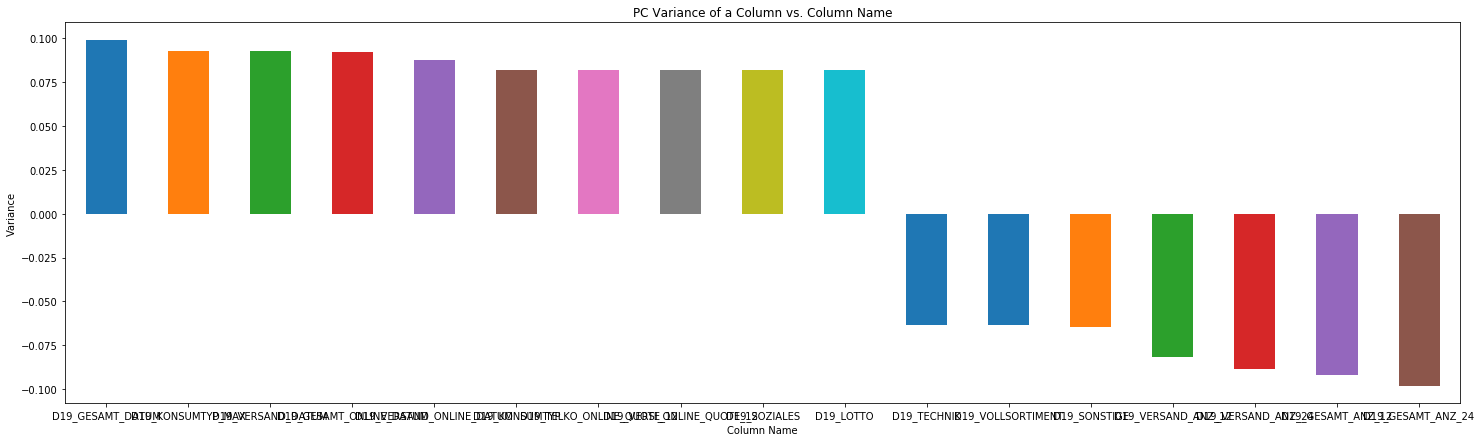

In [137]:
relevant_columns(3)

Now, to fit the data to clustering algorithm in hopes to identify segments of the general population that fit in to the customers of the company. 

In [450]:
def Kmeans_scores(data, K_start, K_end, step=1):
    
    """
    Provides insight into cluster scores for a dataset
    
    INPUT:
    - data: The dataframe that will be organized into a set of clusters
    - K_start: The minimum amount of clusters
    - K_end: The final amount of clusters
    - step: The step count
    
    OUTPUT:
    - score: The calculated cluster score
    
    """
    
    scores = []
    
    print("K-means clustering initiated")
    print("for range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for cluster", n)
        
        kmeans = KMeans(n)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("The score for this cluster is: ", scores[-1])        
    return scores, range(K_start, K_end+1, step)

In [451]:
Kmeans_scores(principal_azdias_Df,1, 20, 1)

K-means clustering initiated
for range min:1, max:20, step:1

Training for cluster 1
The score for this cluster is:  62932231.8627

Training for cluster 2
The score for this cluster is:  25872043.9104

Training for cluster 3
The score for this cluster is:  22480187.2667

Training for cluster 4
The score for this cluster is:  20562954.696

Training for cluster 5
The score for this cluster is:  18079725.8144

Training for cluster 6
The score for this cluster is:  16336855.529

Training for cluster 7
The score for this cluster is:  15097606.1296

Training for cluster 8
The score for this cluster is:  14338808.6867

Training for cluster 9
The score for this cluster is:  13753522.6033

Training for cluster 10
The score for this cluster is:  13423617.6401

Training for cluster 11
The score for this cluster is:  13180251.4881

Training for cluster 12
The score for this cluster is:  12921828.6484

Training for cluster 13
The score for this cluster is:  12685818.6487

Training for cluster 14
Th

([62932231.862665765,
  25872043.910362098,
  22480187.266686402,
  20562954.695973374,
  18079725.814441137,
  16336855.529040363,
  15097606.129550435,
  14338808.686683072,
  13753522.603302892,
  13423617.640131598,
  13180251.488080585,
  12921828.648448408,
  12685818.648674319,
  12383145.468726838,
  12209806.860957347,
  12047788.466209233,
  11857035.197204774,
  11706112.807168461,
  11562120.082899287,
  11542678.684059352],
 range(1, 21))

In [452]:
scores = ([62932231.862665765,
  25872043.910362098,
  22480187.266686402,
  20562954.695973374,
  18079725.814441137,
  16336855.529040363,
  15097606.129550435,
  14338808.686683072,
  13753522.603302892,
  13423617.640131598,
  13180251.488080585,
  12921828.648448408,
  12685818.648674319,
  12383145.468726838,
  12209806.860957347,
  12047788.466209233,
  11857035.197204774,
  11706112.807168461,
  11562120.082899287,
  11542678.684059352])

In [453]:
from matplotlib import pyplot as plt

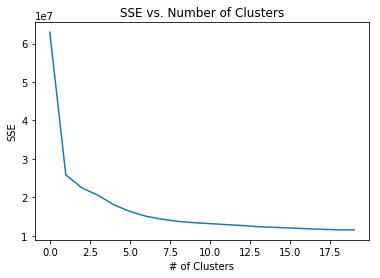

In [454]:
plt.plot(scores)
plt.xlabel("# of Clusters")
plt.ylabel("SSE")
plt.title("SSE vs. Number of Clusters")
plt.show()

The graph above is useful to determine how many clusters should be selected. The 'elbow method' is the industry standard whereupon the number is chosed based on when the curve starts to flatten out. This is a very good 'elbow' shape because the line is nearly horizontal when the cluster # gets larger than 10. That means the analysis was done well and the model should be good at predicting things. It looks like 8 is a good number to choose for the number of clusters so 8 it will be. 

In [456]:
kmeans = KMeans(8, random_state=21)

kmeans.fit(principal_azdias_Df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=21, tol=0.0001, verbose=0)

In [457]:
azdias_clusters = kmeans.predict(principal_azdias_Df)

In [459]:
azdias_clusters = pd.Series(azdias_clusters)

In [460]:
azdias_clusters.value_counts().sort_index()

0    41559
1    14855
2      961
3    73769
4     5001
5     6772
6    34018
7     1309
dtype: int64

In [461]:
azdias_groups = list(azdias_clusters.value_counts().sort_index().values)
azdias_groups

[41559, 14855, 961, 73769, 5001, 6772, 34018, 1309]

In [462]:
azdias_groups_percentages = list((azdias_groups/sum(azdias_groups))*100)
azdias_groups_percentages

[23.315791835910325,
 8.33408137160297,
 0.53914858284149825,
 41.386526334687282,
 2.8057045398442582,
 3.7992863714907656,
 19.085074392405915,
 0.73438657121698347]

In [463]:
customers_clusters = kmeans.predict(principal_customers_Df)

In [464]:
customers_clusters = pd.Series(customers_clusters)

In [465]:
customers_clusters.value_counts().sort_index()

0     5153
1    11845
3    61985
4    12777
5      982
6     2770
7      314
dtype: int64

In [466]:
customer_groups = list(customers_clusters.value_counts().sort_index().values)
customer_groups

[5153, 11845, 61985, 12777, 982, 2770, 314]

There a strange result that no value was given for the second cluster in the customers data frame. It must be 0 so that will be imputed into the list.

In [472]:
customer_groups.insert(2,0)
customer_groups

[5153, 11845, 0, 61985, 12777, 982, 2770, 314]

In [474]:
customer_groups_percentages = (customer_groups/sum(customer_groups))*100
customer_groups_percentages = list(customer_groups_percentages)
customer_groups_percentages

[5.3774549704673058,
 12.360945881076118,
 0.0,
 64.684949804854625,
 13.333542044956484,
 1.0247740696679397,
 2.8906559806315615,
 0.3276772483459604]

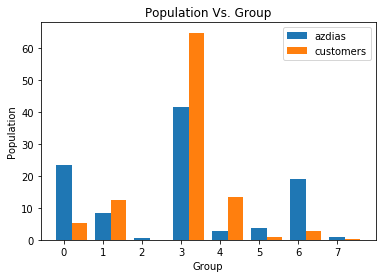

In [476]:
w = 0.4
x = list(range(8))
x2 = [i + w for i in x] 
#plt.figure(figsize=(15, 10))
plt.bar(x, azdias_groups_percentages, w, label = "azdias")
plt.bar(x2, customer_groups_percentages, w, label = "customers")
plt.xlabel("Group")
plt.ylabel("Population")
plt.title("Population Vs. Group")
plt.xticks(x)
plt.legend()
plt.show()


It looks like customers are nested into clusters 1, 3, and 4, especially 4, at least in terms of proportion. The most populous cluster for customers though is cluster 3. People in any of the other clusters are not likely to want to be customers for the company in question. 

Next, get the indices of the azdias dataframe that belong to a cluster. For example, to find out which customers in the azdias dataframe are in the O'th or the first cluster, the code below can provide this information:

In [477]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = principal_azdias_Df.index.values
cluster_map['cluster'] = kmeans.labels_

In [478]:
cluster_map[cluster_map.cluster == 0][1:20]

,data_index,cluster
16,16,0
19,19,0
22,22,0
28,28,0
30,30,0
31,31,0
34,34,0
42,42,0
46,46,0
47,47,0


In [479]:
cluster_map[cluster_map.cluster == 1][1:20]

,data_index,cluster
5,5,1
27,27,1
39,39,1
49,49,1
50,50,1
60,60,1
68,68,1
103,103,1
108,108,1
115,115,1


More analysis can be done in this Unsupervised Model such as determining what columns have the most variance for a given cluster. But, at this point as long as there is enough information about new customers the model can determine what cluster they belong to and therefore whether they may be a potential customer or not. It should be stated however that the steps of PCA will need to be applied to whatever new set of data is inspected so it is congruent with the clustering model.

## EVALUATION II: Supervised Learning Model

Now that it is more clear which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, the model will be verified with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, a prediction will be created on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [87]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [274]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [88]:
response = mailout_train['RESPONSE']
response.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64

In [89]:
mailout_train = mailout_train.drop(['RESPONSE'], axis = 1)

Now for the Supervised Learning section of the project. In this step the data 'mailout_train' will be cleaned and processed into a 'machine learning' algorithm and used to create a model that can predict if individual(s) in a general population will likely be customers or not. 

First a function that contains all of the steps to process the 'azdias' and 'customers' dataframes will be created and used to clean the 'mailout_train' dataframe in one full swoop. 

In [219]:
percent_missing(mailout_train)[1:20]

ALTER_KIND3       99.594991
ALTER_KIND2       98.240305
ALTER_KIND1       95.372655
KK_KUNDENTYP      58.926493
EXTSEL992         37.121177
HH_DELTA_FLAG     22.526884
W_KEIT_KIND_HH    22.526884
KBA05_MAXVORB     20.129417
KBA05_MOTOR       20.129417
KBA05_MOD4        20.129417
KBA05_MOD3        20.129417
KBA05_MOD2        20.129417
KBA05_MOD1        20.129417
KBA05_MAXSEG      20.129417
KBA05_KRSZUL      20.129417
KBA05_MOTRAD      20.129417
KBA05_MAXBJ       20.129417
KBA05_MAXAH       20.129417
KBA05_KW3         20.129417
dtype: float64

In [90]:
def convert_pj_to_dec(val):
    """
    Converts value of feature PRAEGENDE_JUGENDJAHRE to a DECADE value.

    INPUT:
    - val (int): original value

    OUTPUT:
    - int: converted value (0: 40s, 1: 50s, 2: 60s, 3: 70s, 4: 80s, 5: 90s)
    """
    
    result = val
    if (val > 0 and val <= 2):
        result = 0 #40s
    elif (val <= 4):
        result = 1 #50s
    elif (val <= 7):
        result = 2 #60s
    elif (val <= 9):
        result = 3 #70s
    elif (val <= 13):
        result = 4 #80s
    elif (val <= 15):
        result = 5 #90
    return result

def convert_pj_to_move(val):
    """
    Converts value of feature PRAEGENDE_JUGENDJAHRE to a MOVEMENT value.

    INPUT:
    - val (int): original value

    OUTPUT:
    - int: converted value (0: Mainstream, 1: Avantgarde)
    """
    
    result = val
    if (val in [1,3,5,8,10,12,14]):
        result = 0 # M
    elif (val in [2,4,6,7,9,11,13,15]):
        result = 1 # A
    return result


def convert_mixed(df, col_name):
    df_col = df[col_name]
    values = df_col.value_counts(ascending = False)
    df_col = pd.DataFrame(df_col)
    prior_values = values.index
    prior_values = list(prior_values)
    new_values =  list(range(len(prior_values)))
    df_col = df_col.replace(prior_values, new_values)
    return df_col

def fix_LP_cols(df):
    
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)  


def clean_df(df):
    
    """
    Cleans up the dataframe by dropping undesirable columns and filling in blank data

    INPUT:
    - df: a pandas dataframe

    OUTPUT:
    - df: a dataframe that has been processed
    """
    
    
    customers_columns = customers.columns
    attributes_described = list(feature_values["Attribute"].unique())
    undescribed_columns_azdias = [col for col in customers_columns if col not in attributes_described]
    features_list = list(feature_values['Attribute'].unique())
    feature_columns_to_drop = [col for col in features_list if col not in df.columns]
    rows_to_drop = feature_values[feature_values['Attribute'].isin(feature_columns_to_drop)]
    feature_values.drop(rows_to_drop.index, inplace = True)


    df['year'] = pd.DatetimeIndex(df['EINGEFUEGT_AM']).year
    df = df.drop(['EINGEFUEGT_AM'], axis=1)
    df = pd.DataFrame(df)

    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    df[cols] = df[cols].replace({"X": np.NaN, "XX": np.NaN})
    df[cols] = df[cols].astype(float)

    unknown_df = feature_values[feature_values['Meaning'] == 'unknown']
    unknown = pd.Series(unknown_df['Value'].values, index=unknown_df['Attribute'])
    neg_one_columns = unknown_df[unknown_df['Value']== -1].Attribute
    neg_one_columns = list(neg_one_columns)

    #df[neg_one_columns] = df[neg_one_columns].replace({'-1': np.NaN})
    
    #df = fix_LP_cols(df)
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)

    
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_dec(x))
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_move(x))


    df = df.drop(['LP_STATUS_FEIN','LP_FAMILIE_FEIN','CAMEO_DEU_2015', 'GEBURTSJAHR', 
                  'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'PRAEGENDE_JUGENDJAHRE',
                  'EXTSEL992', 'KK_KUNDENTYP',  'OST_WEST_KZ', 'CAMEO_INTL_2015','AGER_TYP'], axis = 1)
    
    df['D19_LETZTER_KAUF_BRANCHE'] = convert_mixed(df,'D19_LETZTER_KAUF_BRANCHE')
    
    for col in df.columns:   
        df.fillna(customers[col].median(), inplace = True)
    
    
    return df

In [91]:
mailout_train = clean_df(mailout_train)
mailout_train.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
0,1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,9.0,3.0,3,2,4,1992.0,3.0,4.0,0,0
1,1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,9.0,7.0,1,2,3,1997.0,3.0,2.0,3,0
2,1776,1.0,9.0,7.0,0.0,96139.5,0.0,0.0,1.0,0.0,...,9.0,2.0,3,1,4,1995.0,1.0,4.0,0,1
3,1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,9.0,1.0,3,2,4,1992.0,1.0,4.0,0,1
4,1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,9.0,3.0,3,1,3,1992.0,4.0,1.0,1,0


In [222]:
len(azdias.columns)

358

In [223]:
extra_columns = [col for col in mailout_train.columns if col not in azdias.columns]
extra_columns

[]

In [224]:
extra_columns = [col for col in azdias_normalized.columns if col not in mailout_train.columns]
extra_columns

['Temp']

In [225]:
feature_values[feature_values['Attribute'] == 'Temp']

,Attribute,Description,Value,Meaning


Checking to make sure all of the columns are the same in 'mailout_train' and 'azdias' reveals that there is a column called 'Temp' in 'azdias' that was never explored. There is no description of it in the 'feature_values' data frame and it probably doesn't make much difference though since the 'mailout_train' dataframe is the one that is being used to fit the machine learning model. 

In [88]:
azdias['Temp'].head()

395430    637523.0
620626        22.0
376138        33.0
229799        29.0
594744        12.0
Name: Temp, dtype: float64

The variable 'response' is the dependent variable. It says whether or not the customer decided to become a customer for the mail order catalog company. 

In [150]:
percent_missing(mailout_train).head()

MOVEMENT           0.0
KBA05_HERSTTEMP    0.0
KBA05_ALTER4       0.0
KBA05_ANHANG       0.0
KBA05_ANTG1        0.0
dtype: float64

In [104]:
x_mail = mailout_train.values
x_mail = StandardScaler().fit_transform(x_mail) # normalizing the features

In [105]:
mail_columns = mailout_train.columns

In [106]:
x_mail =  pd.DataFrame(x_mail, columns= mail_columns)

In [107]:
x_mail.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
0,-1.656309,-0.440039,-0.440088,-0.484086,-0.469916,-0.487369,-0.440026,-0.440053,-0.469958,-0.440024,...,-0.440016,-0.470169,0.174577,0.824885,0.736410,-0.470175,-0.474636,-0.474617,-1.295851,-0.623381
1,-1.655987,-0.439954,-0.439947,-0.483954,-0.470294,-0.487369,-0.440026,-0.440024,-0.470283,-0.440024,...,-0.440016,-0.470061,-1.608634,0.824885,-0.200391,-0.470037,-0.474636,-0.474671,1.046243,-0.623381
2,-1.655785,-0.440039,-0.440060,-0.484113,-0.470321,2.051839,-0.440026,-0.440081,-0.470283,-0.440024,...,-0.440016,-0.470196,0.174577,-1.212290,0.736410,-0.470092,-0.474690,-0.474617,-1.295851,1.604156
3,-1.668538,-0.440039,-0.440145,-0.484139,-0.470213,-0.487369,-0.440026,-0.440024,-0.470202,-0.440024,...,-0.440016,-0.470223,0.174577,0.824885,0.736410,-0.470175,-0.474690,-0.474617,-1.295851,1.604156
4,-1.655502,-0.440039,-0.440060,-0.484060,-0.468889,-0.487369,-0.440026,-0.440053,-0.469121,-0.440024,...,-0.440016,-0.470169,0.174577,-1.212290,-0.200391,-0.470175,-0.474609,-0.474698,-0.515153,-0.623381


Before fitting the dataframe 'x_mail' to a machine learning model without binary output 'response', the dimensionality of it will be reduced to avoid overfitting. Having only 12 principal components retain 85.2% of the variance of the 'azdias' dataframe so that is the size that will be attempted to fit.

In [108]:
pca = PCA(n_components = 75)
pca_mail = pca.fit_transform(x_mail)

In [112]:
feat_cols = ['P.C. '+str(i) for i in range(75)]

In [24]:
pc_mail_df = pd.DataFrame(data = pca_mail, columns = feat_cols)
pc_mail_df.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 65,P.C. 66,P.C. 67,P.C. 68,P.C. 69,P.C. 70,P.C. 71,P.C. 72,P.C. 73,P.C. 74
0,-7.495826,-0.500524,-3.948264,1.210664,-2.543321,0.556144,1.178524,-0.118713,-0.621463,0.781439,...,0.459092,-0.010328,0.105996,-0.031701,-0.625493,-0.532874,-0.276764,-0.163147,0.245582,-0.023406
1,-8.125546,-0.699086,4.911442,-1.439897,-2.475683,-0.962152,5.167916,1.094141,4.417822,1.400414,...,0.266045,-0.370430,1.717685,0.444816,1.644650,0.381429,0.412858,-0.393082,-0.125464,0.380919
2,-7.381826,-0.588520,-0.667121,-0.242855,3.081755,1.412323,1.850165,-2.150714,-2.147735,-1.714111,...,0.834902,0.032604,-0.019122,-0.949389,-0.672367,0.515418,-0.115340,0.905896,0.287028,-0.362820
3,-7.603236,-0.513040,-3.665246,1.136862,-1.980249,0.796814,0.320400,-0.324756,1.194869,-1.664059,...,1.041387,-0.926700,-0.022180,-0.311884,-0.315590,-0.015429,0.254292,-0.277081,-0.231295,0.042101
4,-7.444643,-0.498296,-2.087546,-0.111940,2.496026,0.368508,-0.718332,0.478008,-0.825087,1.324552,...,-0.902727,-0.515766,0.226254,0.622598,-0.362207,0.460724,0.176239,-0.217304,0.402162,0.003088


In [109]:
pickle_out = open("pc_mail_df","wb")
pickle.dump(pc_mail_df, pickle_out)
pickle_out.close()

In [92]:
pickle_in = open("pc_mail_df","rb")
pc_mail_df = pickle.load(pickle_in)

In this step machine learning models will evaluate the x_mail data and be scored using the function called "model_score". It uses ROC AUC to score the model. The higher ROC AUC score the better the model is at accurately predicting whether a customer falls into one of two classes, 1-They will be customer, 0-They will not be a customer. The max score is 1, a score of 0.5 means the model can only predict the class half the time and that would be a useless model. Additionally the model informs as to what hyperparameter values should be used to fine tune the model and increase performance using GridSearchCV and returning 'grid_best_score_', the hyperparameter values. 

In [123]:
def model_score(model, param_grid, X_train= pc_mail_df, y_train=response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - model (classifier): classification model to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - model_score: input classifier fitted to the training data
    """
    max_features_range = np.arange(1,6,1)
    n_estimators_range = np.arange(10,210,10)
    param_grid = dict(max_features = max_features_range, n_estimators = n_estimators_range)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv = cv)
    grid.fit(X_train, y_train)
    print('grid best score: ',grid.best_score_)
    
    return ('best estimator :', grid.best_estimator_, 'best_params: ', grid.best_params)

In [120]:
# Run feature values dataframes, mailout_train, and response, 

When the dependent variable ("response" in this case) is a zero or one, this makes it a classification model. In essence from a purely mathematical standpoint this problem is solved through Logistic Regression. The independent variables are the values in each of the columns where one row represents one household, and the the machine learning algorithm must find what coefficients best fit the data to give the correct output for that row be it 0 or 1 where 0 means that the household/individual did not choose to become a customer and 1 means they did. There are other classification models such as Random Forest, Bagging, AdaBoost, and Gradient Boost. They all do the same thing in that they are fitting the data to the predictive outcome. Some may perform better than others, and how they work exactly will not be explored in this project. To know which will perform best try them all out and see which one(s) give the highest performance score. As stated earlier, the ROC AUC score will be the determining criteria for the models. 

In [305]:
random_forest = RandomForestClassifier(random_state= 9)
model_score(random_forest, {})

0.509656962005


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [94]:
log_reg = LogisticRegression(random_state=9)
log_reg = model_score(log_reg, {})

0.647868779703


In [307]:
bag_class = BaggingClassifier(random_state=12)
model_score(bag_class, {})

0.516455643925


BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=12,
         verbose=0, warm_start=False)

In [27]:
ada_boost = AdaBoostClassifier(random_state=12)
ada_boost_accuracy = model_score(ada_boost, {})


0.626518785504


This is a high score compared to the other classifiers but for some reason the 'model_score' function doesn't produce any suggested hyperparameters for the AdaBoostClassifier. 

In [122]:
# GradientBoostingClassifier
grad_boost = GradientBoostingClassifier(random_state=9)
grad_boost = model_score(grad_boost, {})
grad_boost

0.645435241638


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=90,
              presort='auto', random_state=9, subsample=1.0, verbose=0,
              warm_start=False)

The most successful classifiers are 'AdaBoost' and 'GradientBoost' at 73.6% and 75.4% respectively. The last step is to fine tune some of these classifiers using hyperparameters that are suggested to try to get even better results.

In [44]:
grad_boost = GradientBoostingClassifier(random_state=9)
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 4],
              'n_estimators':[85],
              'random_state': [9]
             }
grad_boost_tuned =model_score(grad_boost, param_grid)
grad_boost_tuned

0.653072993066


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=85,
              presort='auto', random_state=9, subsample=1.0, verbose=0,
              warm_start=False)

Although there were no suggested hyperparameter values for the AdaBoostClassifier a few will be chosen anyway to see if that helps the score improve. 

In [248]:
ada_boost = AdaBoostClassifier(random_state=9)
param_grid = {
              'n_estimators':[10],
              'random_state': [9]
             }

ada_boost_tuned = model_score(ada_boost, param_grid)
ada_boost_tuned

0.607723744653


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=9)

And it appears that both classifiers after having been fine tuned have improved scores of 76.3% for GradientBoost and 75.7% for AdaBoost. Therefore GradientBoost will be used for the final test data set for the Kaggle competition. 

The results of the classifier scores will be shown in a bar plot below. 

<Container object of 7 artists>

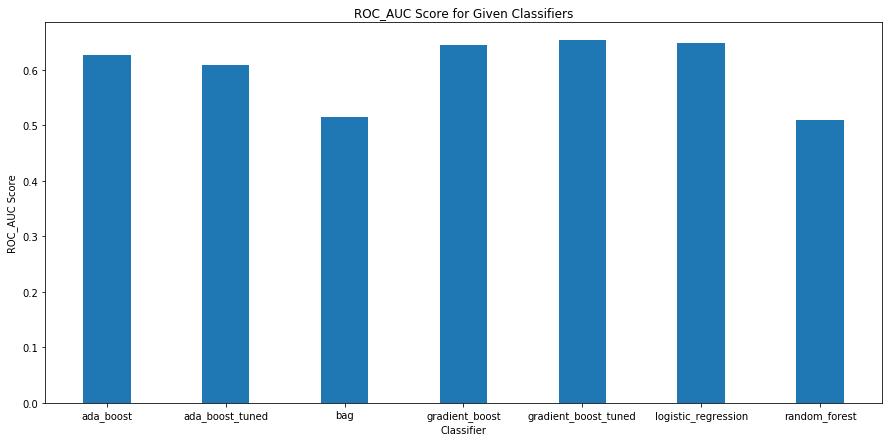

In [3]:
scores = [.509, .648, .516, .627, .645, .653, .608]
models = [ 'random_forest', 'logistic_regression', 'bag', 'ada_boost', 'gradient_boost', 'gradient_boost_tuned',
         'ada_boost_tuned']
plt.figure(figsize=(15,7))
plt.xlabel("Classifier")
plt.ylabel("ROC_AUC Score")
plt.title("ROC_AUC Score for Given Classifiers")
plt.bar(models, scores, 0.4)

So as for the question, "Why are the results different?" Much time could be spent on this question as these classifier algorithms can be very complex but essentially it is because the algorithms are more effective on the ones that perform better. The only way to know is trial by error. The highest performing models on the cross-validation data were 'gradient_boost_tuned', logistic regression, and 'grad_boost'.

It would also certainly be useful for the company to know what feature columns are most relevant for that the GradientBoost classifier model because that way the company would know where to move forward for data collection and customer information. They can save valuable time and resources by focusing on what is important. How to do this is shown below for the top 10 most important columns for an example.

In [122]:
# analyse the most important features of the model
top_features = pd.DataFrame({'FI':grad_boost_tuned.feature_importances_}, index = x_mail.columns)
top_features_sorted = top_features.sort_values(by=['FI'], ascending=False)
top_features_sorted.head(10)

,FI
D19_SOZIALES,0.227658
ANZ_KINDER,0.168950
LNR,0.037493
ANZ_STATISTISCHE_HAUSHALTE,0.027971
D19_BANKEN_ANZ_24,0.023854
D19_VERSI_ONLINE_DATUM,0.020545
D19_BANKEN_LOKAL,0.020096
ANZ_TITEL,0.018714
EINGEZOGENAM_HH_JAHR,0.017086
CAMEO_DEUG_2015,0.015809


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [95]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [96]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [97]:
mailout_test = clean_df(mailout_test)
mailout_test.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
0,1754,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,...,9.0,3.0,3,1,4,1993.0,1.0,3.0,0,1
1,1770,1.0,0.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,...,9.0,5.0,3,1,4,1992.0,3.0,1.0,2,0
2,1465,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,...,9.0,4.0,3,2,4,1992.0,4.0,1.0,2,1
3,1470,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,9.0,2.0,3,2,4,1992.0,1.0,3.0,2,0
4,1478,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,...,9.0,7.0,4,2,4,1992.0,3.0,1.0,3,0


In [133]:
lnr = mailout_test.LNR

In [134]:
x_mail_test = mailout_test.values
x_mail_test = StandardScaler().fit_transform(x_mail_test)

In [135]:
mail_columns = mailout_test.columns

In [101]:
x_mail_test =  pd.DataFrame(x_mail_test, columns= mail_columns)
x_mail_test.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,year,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY,DECADE,MOVEMENT
0,-1.665871,-0.437804,-0.437881,-0.483679,-0.465574,-0.484607,-0.437792,-0.437790,-0.465563,-0.437789,...,-0.437781,-0.465475,0.178441,-1.213276,0.728696,-0.465453,-0.469947,-0.469901,-1.303567,1.600254
1,-1.665225,-0.437804,-0.438079,-0.483838,-0.465085,-0.484607,-0.437792,-0.437818,-0.465046,-0.437789,...,-0.437781,-0.465420,0.178441,-1.213276,0.728696,-0.465481,-0.469893,-0.469955,0.255175,-0.624901
2,-1.677546,-0.437577,-0.437626,-0.483546,-0.465574,-0.484607,-0.437792,-0.437733,-0.465563,-0.437789,...,-0.437781,-0.465448,0.178441,0.824215,0.728696,-0.465481,-0.469866,-0.469955,0.255175,1.600254
3,-1.677344,-0.437634,-0.438079,-0.483838,-0.465601,-0.484607,-0.437792,-0.437846,-0.465590,-0.437789,...,-0.437781,-0.465502,0.178441,0.824215,0.728696,-0.465481,-0.469947,-0.469901,0.255175,-0.624901
4,-1.677021,-0.437804,-0.437484,-0.483493,-0.465601,-0.484607,-0.437792,-0.437733,-0.465590,-0.437789,...,-0.437781,-0.465366,1.070811,0.824215,0.728696,-0.465481,-0.469893,-0.469955,1.034546,-0.624901


In [110]:
pca_test = pca.fit_transform(x_mail_test)

In [113]:
pc_test_df = pd.DataFrame(data = pca_test, columns = feat_cols)
pc_test_df.head()

,P.C. 0,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6,P.C. 7,P.C. 8,P.C. 9,...,P.C. 65,P.C. 66,P.C. 67,P.C. 68,P.C. 69,P.C. 70,P.C. 71,P.C. 72,P.C. 73,P.C. 74
0,-8.017105,-0.651573,0.045141,0.144431,2.293468,2.305246,-0.402194,-2.885343,0.848021,-0.488360,...,0.266769,0.213213,0.681086,-0.714412,-0.560175,0.084456,0.104404,0.867883,0.053636,0.112053
1,-7.546122,-0.469903,-3.052303,0.391623,1.609278,1.097355,0.352686,-0.019009,0.374818,-0.709623,...,-0.191681,-0.862635,-0.194920,0.817025,0.595587,-0.016719,0.192719,-0.984108,-0.064255,-0.021642
2,-7.508158,-0.477586,-3.574387,0.955117,-1.226470,0.782585,0.145190,0.209421,-0.982008,2.530948,...,0.309603,0.246809,0.006870,-0.100574,0.909088,0.426877,-0.361918,-0.593116,-0.111275,0.143992
3,-7.166884,-0.491947,-3.330307,0.528003,-2.436927,-0.211023,-0.071306,-0.367444,0.227421,-0.113372,...,-0.422703,1.031862,0.060534,-0.669657,0.504510,-0.588418,0.385020,-0.087849,-0.035712,0.156154
4,-8.969154,-0.980723,12.054525,-2.290884,-3.746079,-1.008406,4.770732,-0.046394,4.686638,3.365845,...,0.163604,-0.013676,-0.395640,0.012291,0.609866,0.739838,-0.572618,-0.221370,-0.932282,1.185580


In [117]:
response_log_reg = log_reg.predict(pc_test_df)

In [115]:
result_log_reg = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_log_reg})

In [118]:
result_log_reg[result_log_reg['RESPONSE']>0]

,LNR,RESPONSE
10146,41575,1
23147,18434,1
31792,677,1


In [54]:
response = grad_boost.predict(pc_test_df)
response

In [125]:
response3 = grad_boost.predict(pc_test_df)
response3

array([0, 0, 0, ..., 0, 0, 0])

In [137]:
result3 = pd.DataFrame({'LNR':lnr, 'RESPONSE':response3})
result3.head()

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0


In [140]:
result3.to_csv(path_or_buf='./result3.csv', index=False)

In [139]:
result3[result3['RESPONSE']>0]

,LNR,RESPONSE
100,21374,1
653,31910,1
816,13685,1
1438,61996,1
1590,54196,1
1705,45452,1
2081,72288,1
2471,27348,1
3634,84296,1
3831,65786,1


In [51]:
result = pd.DataFrame(index=mailout_test_LNR, data= response)
result.to_csv(path_or_buf='./result.csv', index=False)
result.head()

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0
5,1782,0
6,1485,0
7,1519,0
8,1835,0
9,1522,0


In [56]:
result[result["RESPONSE"]>0]

,LNR,RESPONSE
89,12608,1
194,25232,1
475,41666,1
552,5661,1
736,35426,1
743,35106,1
807,13934,1
840,14494,1
903,4124,1
924,14057,1


Try doing PCA and improving results. 

Selecting subsets of a DataFrame https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html

PCA article:
https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c

optimizing hyperparameters: https://medium.com/analytics-vidhya/optimize-hyperparameters-with-gridsearch-d351b0fd339d